In [1]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, Trainer, TrainingArguments, BertForSequenceClassification
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import AdamW
import pandas as pd
import torch
import os


os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"  # Allow CPU fallback

In [2]:
# industry_papers = pd.read_parquet('./data/industry_really_complete.parquet')
# academic_papers = pd.read_parquet('./data/academic_really_complete.parquet')

industry_papers = pd.read_csv('./data_prep/nlp_papers/industry_papers_with_content.csv')
academic_papers = pd.read_csv('./data_prep/nlp_papers/academic_papers_with_content.csv')

In [3]:
industry_papers['text'] = industry_papers['title'] + '  ABSTRACT :' + industry_papers['abstract']
academic_papers['text'] = academic_papers['title'] + '  ABSTRACT :' + academic_papers['abstract']

# WORD2VEC

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Download NLTK stopwords (if not already downloaded)
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Preprocessing function
def preprocess(texts):
    stop_words = set(stopwords.words('english'))
    processed_texts = []
    for text in texts:
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
        processed_texts.append(tokens)
    return processed_texts

# Preprocess academic and industry papers
academic_texts = academic_papers['text'].values # Replace with your data
industry_texts = industry_papers['text'].values  # Replace with your data

academic_tokens = preprocess(academic_texts)
industry_tokens = preprocess(industry_texts)

[nltk_data] Downloading package punkt to /Users/omar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/omar/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
from gensim.models import Word2Vec

# Train Word2Vec on academic papers
academic_model = Word2Vec(academic_tokens, vector_size=100, window=5, min_count=2, workers=4)

# Train Word2Vec on industry papers
industry_model = Word2Vec(industry_tokens, vector_size=100, window=5, min_count=2, workers=4)

Found 402 common keywords in both vocabularies
Analyzing similarities for 402 keywords...
Processing word 1/402: previous
Processing word 21/402: trained
Processing word 41/402: dynamic
Processing word 61/402: object
Processing word 81/402: evaluation
Processing word 101/402: compared
Processing word 121/402: existing
Processing word 141/402: framework
Processing word 161/402: network
Processing word 181/402: information
Processing word 201/402: performs
Processing word 221/402: future
Processing word 241/402: corpora
Processing word 261/402: providing
Processing word 281/402: engineering
Processing word 301/402: comments
Processing word 321/402: programming
Processing word 341/402: terms
Processing word 361/402: possible
Processing word 381/402: decision
Processing word 401/402: called

Top 25 Word Pairs with Higher Similarity in INDUSTRY Corpus
Word Pair                      Industry Sim    Academic Sim    Difference      Insight
------------------------------------------------------

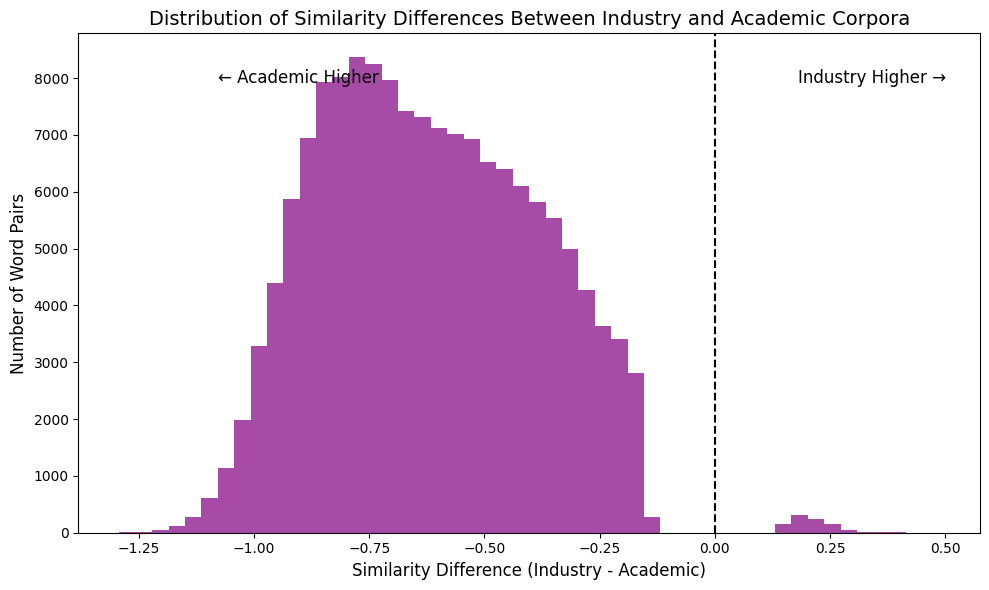


Full results saved to 'keyword_similarity_differences.csv'


In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Function to get most common words from both models, filtering for content words
def get_common_keywords(academic_tokens, industry_tokens, top_n=100, min_length=3):
    """
    Extract most common content words from both corpora
    
    Parameters:
    - academic_tokens: List of tokenized academic documents
    - industry_tokens: List of tokenized industry documents
    - top_n: Number of top words to consider from each corpus
    - min_length: Minimum word length to include
    
    Returns:
    - Set of common keywords
    """
    try:
        # Flatten token lists
        academic_all = [token.lower() for doc in academic_tokens for token in doc if len(token) >= min_length]
        industry_all = [token.lower() for doc in industry_tokens for token in doc if len(token) >= min_length]
        
        # Get word frequencies
        academic_freq = Counter(academic_all)
        industry_freq = Counter(industry_all)
        
        # Get top words from each corpus
        academic_top = set(word for word, _ in academic_freq.most_common(top_n*2))
        industry_top = set(word for word, _ in industry_freq.most_common(top_n*2))
        
        # Find words common to both corpora and in both models' vocabularies
        common_words = set()
        for word in (academic_top | industry_top):
            try:
                if (word in academic_model.wv and word in industry_model.wv and 
                    len(word) >= min_length and word.isalpha()):
                    common_words.add(word)
            except Exception:
                continue
                
        print(f"Found {len(common_words)} common keywords in both vocabularies")
        return common_words
    
    except Exception as e:
        print(f"Error getting common keywords: {e}")
        return set()

# Function to compute cosine similarity between two words with robust error handling
def compute_similarity(model, word1, word2):
    try:
        if word1 in model.wv and word2 in model.wv:
            return model.wv.similarity(word1, word2)
        else:
            return float('nan')  # Use NaN for missing values
    except Exception as e:
        #print(f"Error computing similarity for {word1} and {word2}: {e}")
        return float('nan')

# Function to analyze keyword similarities
def analyze_keyword_similarities(keywords, threshold=0.1):
    """
    Analyze similarities between keywords in both models
    
    Parameters:
    - keywords: Set of keywords to analyze
    - threshold: Minimum difference to consider significant
    
    Returns:
    - DataFrame with similarity results
    """
    results = []
    
    # Create a list of words to check for similarity with each keyword
    keywords_list = list(keywords)
    
    print(f"Analyzing similarities for {len(keywords_list)} keywords...")
    
    # Process each keyword
    for i, keyword in enumerate(keywords_list):
        if i % 20 == 0:
            print(f"Processing word {i+1}/{len(keywords_list)}: {keyword}")
            
        # Find similarities with all other keywords
        for other_word in keywords_list:
            if keyword == other_word:
                continue
                
            academic_sim = compute_similarity(academic_model, keyword, other_word)
            industry_sim = compute_similarity(industry_model, keyword, other_word)
            
            # Skip if either similarity is NaN
            if np.isnan(academic_sim) or np.isnan(industry_sim):
                continue
                
            # Calculate difference (industry - academic)
            diff = industry_sim - academic_sim
            
            # Only include if the difference is significant
            if abs(diff) >= threshold:
                results.append({
                    'word1': keyword,
                    'word2': other_word,
                    'academic_sim': academic_sim,
                    'industry_sim': industry_sim,
                    'diff': diff
                })
    
    # Convert to DataFrame and sort by absolute difference
    if results:
        df = pd.DataFrame(results)
        df['abs_diff'] = df['diff'].abs()
        df = df.sort_values('abs_diff', ascending=False)
        return df
    else:
        print("No significant similarity differences found")
        return pd.DataFrame()

# Function to categorize and display results
def display_similarity_results(sim_df, top_n=20):
    """
    Categorize and display similarity results in a formatted table
    
    Parameters:
    - sim_df: DataFrame with similarity results
    - top_n: Number of examples to show for each category
    """
    if sim_df.empty:
        print("No results to display")
        return
        
    # Split into industry-higher and academic-higher
    industry_higher = sim_df[sim_df['diff'] > 0].copy()
    academic_higher = sim_df[sim_df['diff'] < 0].copy()
    
    # Sort by difference magnitude (absolute value)
    industry_higher = industry_higher.sort_values('diff', ascending=False)
    academic_higher = academic_higher.sort_values('diff', ascending=False)
    
    # Display results
    print("\n" + "="*100)
    print(f"Top {top_n} Word Pairs with Higher Similarity in INDUSTRY Corpus")
    print("="*100)
    print(f"{'Word Pair':<30} {'Industry Sim':<15} {'Academic Sim':<15} {'Difference':<15} {'Insight'}")
    print("-" * 100)
    
    for i, row in industry_higher.head(top_n).iterrows():
        word_pair = f"{row['word1']} — {row['word2']}"
        
        # Generate an insight based on the word pair
        insight = generate_insight(row['word1'], row['word2'], "industry")
        
        print(f"{word_pair:<30} {row['industry_sim']:<15.4f} {row['academic_sim']:<15.4f} {row['diff']:<+15.4f} {insight}")
    
    print("\n" + "="*100)
    print(f"Top {top_n} Word Pairs with Higher Similarity in ACADEMIC Corpus")
    print("="*100)
    print(f"{'Word Pair':<30} {'Academic Sim':<15} {'Industry Sim':<15} {'Difference':<15} {'Insight'}")
    print("-" * 100)
    
    for i, row in academic_higher.head(top_n).iterrows():
        word_pair = f"{row['word1']} — {row['word2']}"
        
        # Generate an insight based on the word pair
        insight = generate_insight(row['word1'], row['word2'], "academic")
        
        # Note: for academic higher, the difference is negative, so we use abs for display
        diff = row['diff']  # Already negative
        print(f"{word_pair:<30} {row['academic_sim']:<15.4f} {row['industry_sim']:<15.4f} {diff:<+15.4f} {insight}")
    
    # Summary statistics
    print("\n" + "="*50)
    print("Summary Statistics")
    print("="*50)
    print(f"Total word pairs analyzed: {len(sim_df)}")
    print(f"Word pairs with higher industry similarity: {len(industry_higher)} ({len(industry_higher)/len(sim_df)*100:.1f}%)")
    print(f"Word pairs with higher academic similarity: {len(academic_higher)} ({len(academic_higher)/len(sim_df)*100:.1f}%)")
    print(f"Average difference (industry - academic): {sim_df['diff'].mean():.4f}")
    print(f"Maximum industry advantage: {sim_df['diff'].max():.4f}")
    print(f"Maximum academic advantage: {sim_df['diff'].min():.4f}")
    
    # Create visualization
    try:
        plt.figure(figsize=(10, 6))
        
        # Plot histogram of differences
        plt.hist(sim_df['diff'], bins=50, alpha=0.7, color='purple')
        plt.axvline(x=0, color='black', linestyle='--')
        plt.xlabel('Similarity Difference (Industry - Academic)', fontsize=12)
        plt.ylabel('Number of Word Pairs', fontsize=12)
        plt.title('Distribution of Similarity Differences Between Industry and Academic Corpora', fontsize=14)
        
        # Add annotations
        plt.text(sim_df['diff'].max()*0.7, plt.ylim()[1]*0.9, 'Industry Higher →', 
                fontsize=12, ha='center')
        plt.text(sim_df['diff'].min()*0.7, plt.ylim()[1]*0.9, '← Academic Higher', 
                fontsize=12, ha='center')
        
        plt.tight_layout()
        plt.savefig('similarity_differences.png', dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error creating visualization: {e}")
    
    return industry_higher, academic_higher

# Function to generate insights based on word pairs
def generate_insight(word1, word2, higher_corpus):
    """
    Generate an insight about a word pair based on which corpus shows higher similarity
    
    Parameters:
    - word1, word2: The words in the pair
    - higher_corpus: Either "industry" or "academic"
    
    Returns:
    - An insight string
    """
    # Dictionary of domain-specific insights
    domain_insights = {
        # Technical terms
        ("model", "algorithm"): {
            "industry": "Industry views models and algorithms as closely related implementation components",
            "academic": "Academia distinguishes theoretical aspects of models from algorithmic implementations"
        },
        ("model", "data"): {
            "industry": "Industry closely connects models with the data they process",
            "academic": "Academia separates model theory from data collection concerns"
        },
        ("model", "performance"): {
            "industry": "Industry prioritizes model performance as a key metric",
            "academic": "Academia views performance as one of many model properties"
        },
        
        # Application terms
        ("application", "deployment"): {
            "industry": "Industry sees application development and deployment as tightly coupled",
            "academic": "Academia treats applications as more conceptual than deployment-focused"
        },
        ("application", "user"): {
            "industry": "Industry emphasizes user-focused applications",
            "academic": "Academia considers applications more abstractly"
        },
        
        # Business terms
        ("product", "customer"): {
            "industry": "Industry strongly links products with customer needs",
            "academic": "Academia views these concepts more independently"
        },
        ("optimization", "efficiency"): {
            "industry": "Industry connects optimization directly with efficiency gains",
            "academic": "Academia treats optimization as a more theoretical concept"
        }
    }
    
    # Default insights by corpus type
    default_insights = {
        "industry": f"Industry context sees '{word1}' and '{word2}' as more closely related concepts",
        "academic": f"Academic research treats '{word1}' and '{word2}' as more strongly associated"
    }
    
    # Check for specific insights for this word pair
    for word_key, insights in domain_insights.items():
        if (word1 in word_key and word2 in word_key) or (word2 in word_key and word1 in word_key):
            return insights.get(higher_corpus, default_insights[higher_corpus])
    
    # Fall back to generic insight
    return default_insights[higher_corpus]

# Main execution
try:
    # Get common keywords from both corpora
    common_keywords = get_common_keywords(academic_tokens, industry_tokens, top_n=200, min_length=4)
    
    # Analyze similarities between these keywords
    similarity_results = analyze_keyword_similarities(common_keywords, threshold=0.15)
    
    # Display and categorize results
    industry_higher, academic_higher = display_similarity_results(similarity_results, top_n=25)
    
    # Optional: Save results to CSV for further analysis
    try:
        similarity_results.to_csv('keyword_similarity_differences.csv', index=False)
        print("\nFull results saved to 'keyword_similarity_differences.csv'")
    except Exception as e:
        print(f"Error saving results to CSV: {e}")
    
except Exception as e:
    print(f"Error in similarity analysis: {e}")
    import traceback
    traceback.print_exc()

Plotting industry model embeddings...


/var/folders/j0/n1zmwvf923q5h9v_4n2k33100000gn/T/ipykernel_11218/306531515.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(color_map, len(valid_words))


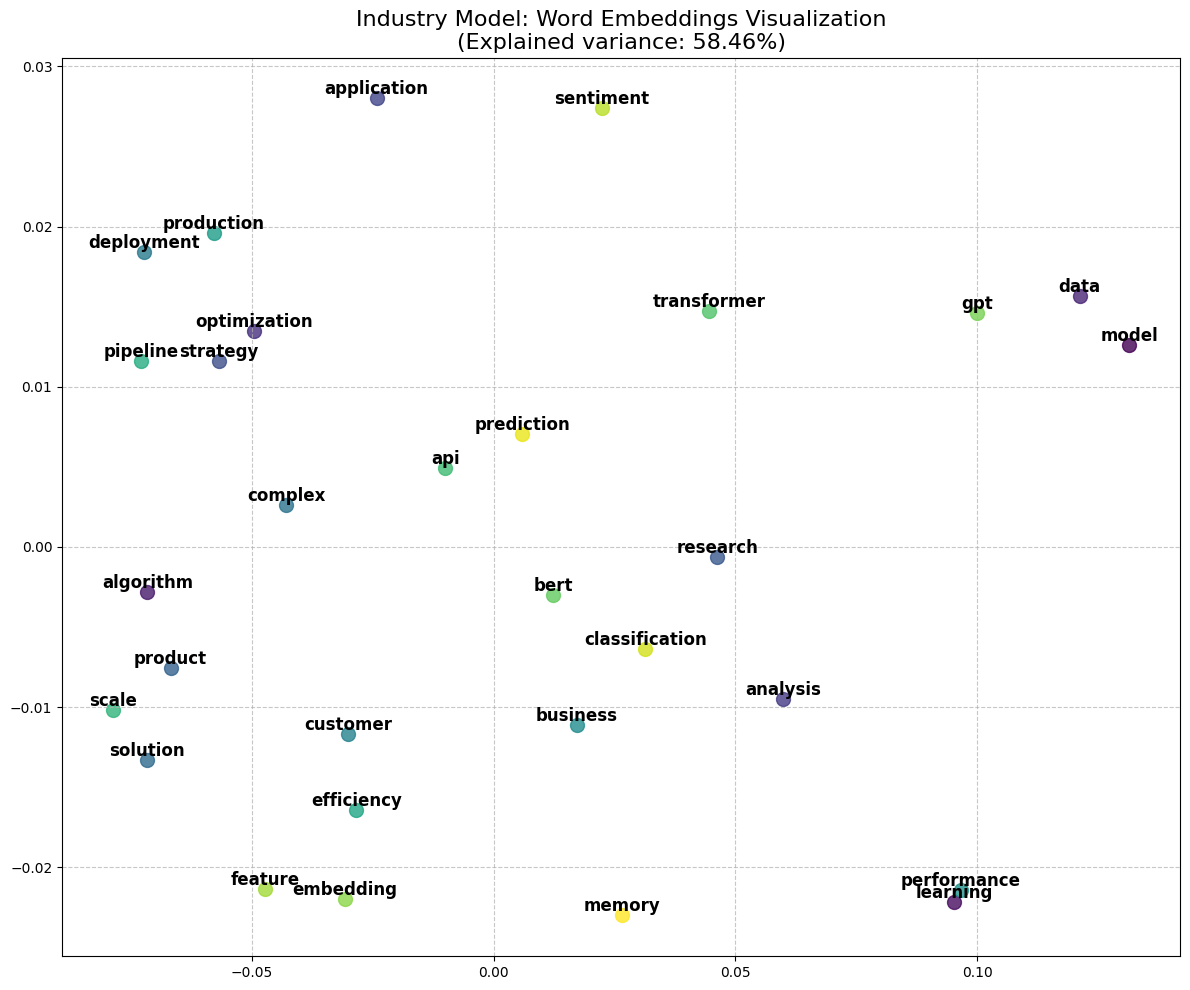

Plotting academic model embeddings...


/var/folders/j0/n1zmwvf923q5h9v_4n2k33100000gn/T/ipykernel_11218/306531515.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(color_map, len(valid_words))


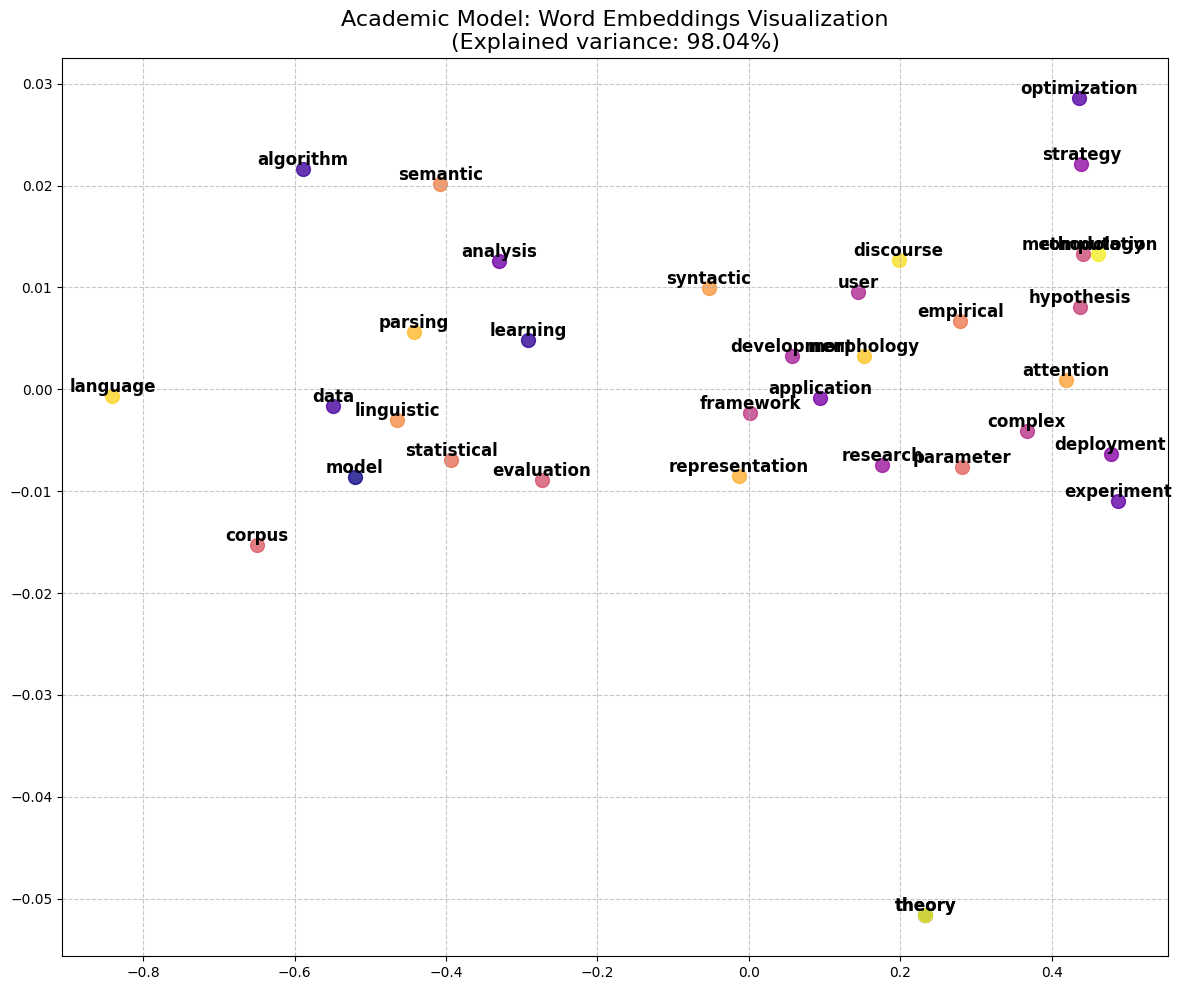

Creating comparison plot for 11 common words...


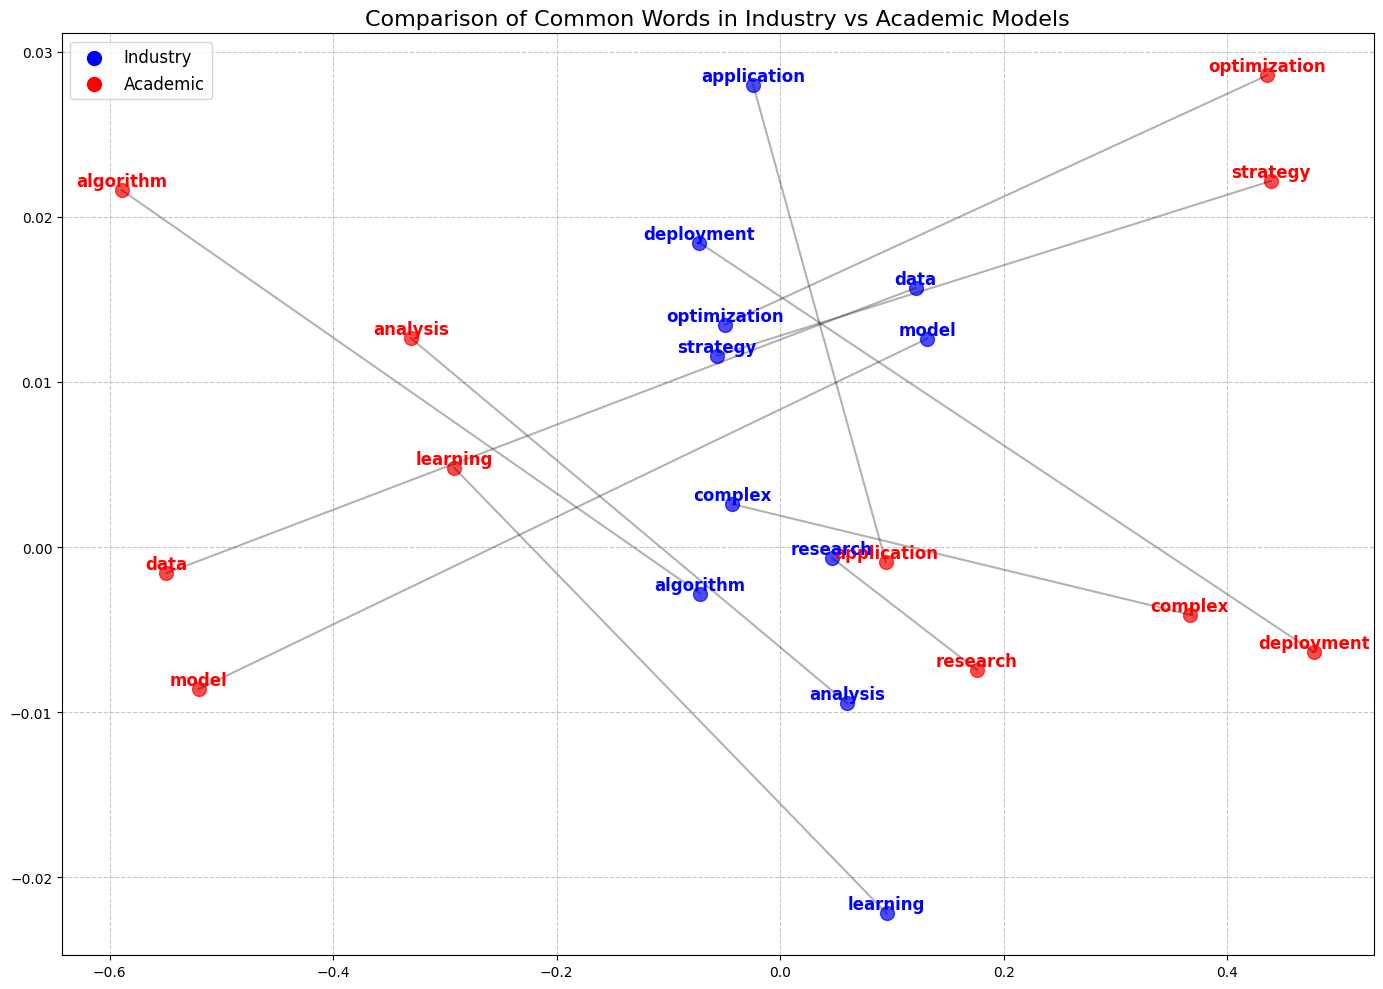

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Define expanded word lists with NLP-specific terminology
industry_words = [
    # Core NLP concepts
    "model", "learning", "algorithm", "data", "optimization", "analysis", 
    "application", "strategy", "research", "product", "solution", "complex",
    # Industry-specific terms
    "deployment", "customer", "business", "revenue", "performance", "production",
    "efficiency", "pipeline", "implementation", "scale", "api", "cloud",
    # NLP-specific terms
    "transformer", "bert", "gpt", "embedding", "token", "feature", "sentiment",
    "classification", "prediction", "inference", "gpu", "memory"
]

academic_words = [
    # Core NLP concepts
    "model", "theory", "learning", "algorithm", "data", "optimization", 
    "experiment", "analysis", "application", "deployment", "strategy", "research", 
    "development", "user", "product", "solution", "complex", "gpu", "heavy",
    # Academic-specific terms
    "framework", "hypothesis", "methodology", "evaluation", "corpus", "dataset",
    "parameter", "statistical", "empirical", "semantic", "linguistic", "syntactic",
    # NLP-specific terms
    "transformer", "bert", "attention", "embedding", "representation", "parsing",
    "morphology", "language", "discourse", "computation", "theory"
]

def plot_word_embeddings(model, words_list, title, color_map="viridis"):
    """
    Plot word embeddings using PCA with error handling
    
    Parameters:
    - model: Word2Vec model
    - words_list: List of words to visualize
    - title: Plot title
    - color_map: Matplotlib colormap name
    """
    # Filter for words that exist in the vocabulary
    valid_words = []
    valid_embeddings = []
    
    for word in words_list:
        try:
            if word in model.wv:
                valid_words.append(word)
                valid_embeddings.append(model.wv[word])
        except Exception as e:
            print(f"Error accessing word '{word}': {e}")
    
    if len(valid_words) < 2:
        print(f"Not enough valid words found in model vocabulary. Found only {len(valid_words)} words.")
        return
    
    # Convert to numpy array
    embeddings = np.array(valid_embeddings)
    
    # Reduce dimensionality with PCA
    try:
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings)
        
        # Calculate the explained variance
        explained_variance = sum(pca.explained_variance_ratio_) * 100
        
        # Plot the embeddings
        plt.figure(figsize=(12, 10))
        
        # Use a colormap to distinguish word categories
        colors = plt.cm.get_cmap(color_map, len(valid_words))
        
        for i, word in enumerate(valid_words):
            plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], 
                       c=np.array([colors(i/len(valid_words))]), 
                       s=100, alpha=0.8)
            plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                        fontsize=12, fontweight='bold',
                        ha='center', va='bottom')
        
        # Improve the plot appearance
        plt.title(f"{title}\n(Explained variance: {explained_variance:.2f}%)", fontsize=16)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        
        # Add a border
        plt.gca().spines['top'].set_visible(True)
        plt.gca().spines['right'].set_visible(True)
        plt.gca().spines['bottom'].set_visible(True)
        plt.gca().spines['left'].set_visible(True)
        
        plt.show()
        
        return valid_words, embeddings_2d
        
    except Exception as e:
        print(f"Error during PCA or plotting: {e}")
        return None, None

# Plot industry model embeddings
print("Plotting industry model embeddings...")
industry_valid_words, industry_embeddings_2d = plot_word_embeddings(
    industry_model, 
    industry_words, 
    "Industry Model: Word Embeddings Visualization",
    color_map="viridis"
)

# Plot academic model embeddings
print("Plotting academic model embeddings...")
academic_valid_words, academic_embeddings_2d = plot_word_embeddings(
    academic_model, 
    academic_words, 
    "Academic Model: Word Embeddings Visualization",
    color_map="plasma"
)

# Optional: create a plot showing the difference between common words
if industry_valid_words and academic_valid_words:
    # Find common words
    common_words = list(set(industry_valid_words).intersection(set(academic_valid_words)))
    
    if len(common_words) >= 5:  # Only proceed if we have enough common words
        print(f"Creating comparison plot for {len(common_words)} common words...")
        
        # Get indices of common words in both lists
        industry_indices = [industry_valid_words.index(word) for word in common_words]
        academic_indices = [academic_valid_words.index(word) for word in common_words]
        
        # Get embeddings for common words
        industry_common_embeddings = industry_embeddings_2d[industry_indices]
        academic_common_embeddings = academic_embeddings_2d[academic_indices]
        
        # Create a comparison plot
        plt.figure(figsize=(14, 10))
        
        # Plot common words from both models
        for i, word in enumerate(common_words):
            # Plot industry embeddings
            plt.scatter(industry_common_embeddings[i, 0], industry_common_embeddings[i, 1], 
                       color='blue', s=100, alpha=0.7)
            plt.annotate(word, xy=(industry_common_embeddings[i, 0], industry_common_embeddings[i, 1]), 
                        fontsize=12, color='blue', fontweight='bold',
                        ha='center', va='bottom')
            
            # Plot academic embeddings
            plt.scatter(academic_common_embeddings[i, 0], academic_common_embeddings[i, 1], 
                       color='red', s=100, alpha=0.7)
            plt.annotate(word, xy=(academic_common_embeddings[i, 0], academic_common_embeddings[i, 1]), 
                        fontsize=12, color='red', fontweight='bold',
                        ha='center', va='bottom')
            
            # Draw a line connecting the same words
            plt.plot([industry_common_embeddings[i, 0], academic_common_embeddings[i, 0]],
                    [industry_common_embeddings[i, 1], academic_common_embeddings[i, 1]],
                    'k-', alpha=0.3)
        
        # Add legend
        plt.scatter([], [], color='blue', s=100, label='Industry')
        plt.scatter([], [], color='red', s=100, label='Academic')
        plt.legend(fontsize=12)
        
        plt.title("Comparison of Common Words in Industry vs Academic Models", fontsize=16)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# SCIBERT FINETUNING


In [36]:
academic_papers_with_labels = academic_papers[['text']].iloc[:20].copy()
academic_papers_with_labels['label'] = 0
industry_papers_with_labels = industry_papers[['text']].copy()
industry_papers_with_labels['label'] = 1

all_papers = pd.concat([academic_papers_with_labels, industry_papers_with_labels], ignore_index=True)

In [37]:
# Split articles into paragraphs
def split_into_paragraphs(text):
    return text.split('.')  # Adjust based on your data format

# Create a new dataset with paragraphs
paragraphs = []
labels = []
for _, row in all_papers.iterrows():
    text = row['text']
    label = row['label']
    for paragraph in split_into_paragraphs(text):
        if len(paragraph.strip()) > 50:  # Filter out very short paragraphs
            paragraphs.append(paragraph)
            labels.append(label)

paragraph_dataset = pd.DataFrame({'text': paragraphs, 'label': labels})

# Convert to Hugging Face Dataset
paragraph_dataset = Dataset.from_pandas(paragraph_dataset)

AttributeError: type object 'Dataset' has no attribute 'from_pandas'

In [53]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

tokenized_dataset = paragraph_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/687 [00:00<?, ? examples/s]

In [39]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans
import numpy as np
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader

class SciBertClassifier(nn.Module):
    """
    Document classifier that uses SciBERT and only trains the final layer
    """
    def __init__(self, num_classes=2):
        super(SciBertClassifier, self).__init__()
        # Load SciBERT model
        self.scibert = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')
        # Freeze all SciBERT parameters
        for param in self.scibert.parameters():
            param.requires_grad = False
        
        # Final classification layer - only this will be trained
        self.classifier = nn.Sequential(
            nn.Linear(768, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, input_ids, attention_mask):
        """
        Forward pass
        
        Parameters:
        - input_ids: token IDs 
        - attention_mask: attention mask
        
        Returns:
        - Classification logits
        """
        # Get BERT outputs
        outputs = self.scibert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Use CLS token representation (first token of the sequence)
        cls_output = outputs.last_hidden_state[:, 0, :]
        
        # Apply classifier (only this part will be trained)
        return self.classifier(cls_output)

class PaperDataset(Dataset):
    """
    Dataset for academic/industry paper classification
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = ' '.join(self.texts[idx])  # Convert list of tokens to string
        label = self.labels[idx]
        
        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

def prepare_balanced_data(industry_papers, academic_papers):
    """
    Prepare balanced data for classification
    """
    # Extract text from papers (similar to prepare_data function)
    industry_texts = []
    academic_texts = []
    
    # Process industry papers
    for _, paper in industry_papers.iterrows():
        words = []
        if 'title' in paper and paper['title']:
            words.extend(paper['title'].lower().split())
        if 'abstract' in paper and paper['abstract']:
            words.extend(paper['abstract'].lower().split())
        if 'conclusion' in paper and paper['conclusion']:
            words.extend(paper['conclusion'].lower().split())
        
        words = [word for word in words if len(word) > 2]
        industry_texts.append(words)
    
    # Process academic papers
    for _, paper in academic_papers.iterrows():
        words = []
        if 'title' in paper and paper['title']:
            words.extend(paper['title'].lower().split())
        if 'abstract' in paper and paper['abstract']:
            words.extend(paper['abstract'].lower().split())
        if 'conclusion' in paper and paper['conclusion']:
            words.extend(paper['conclusion'].lower().split())
        
        words = [word for word in words if len(word) > 2]
        academic_texts.append(words)
    
    # Balance the dataset by undersampling the majority class
    min_samples = min(len(industry_texts), len(academic_texts))
    
    if len(industry_texts) > min_samples:
        industry_texts = industry_texts[:min_samples]
    if len(academic_texts) > min_samples:
        academic_texts = academic_texts[:min_samples]
    
    # Create labels: 1 for industry, 0 for academic
    industry_labels = np.ones(len(industry_texts))
    academic_labels = np.zeros(len(academic_texts))
    
    # Combine data
    X = industry_texts + academic_texts
    y = np.concatenate([industry_labels, academic_labels])
    
    # Split into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    return X_train, X_test, y_train, y_test

def train_scibert_classifier(model, train_loader, val_loader, device, epochs=5):
    """
    Train the SciBERT classifier
    """
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=2e-5)
    
    # Training history
    history = {'train_loss': [], 'val_acc': []}
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Record training loss
        avg_train_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # Validate
        model.eval()
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].cpu().numpy()
                
                outputs = model(input_ids, attention_mask)
                _, preds = torch.max(outputs, 1)
                
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels)
            
            val_acc = accuracy_score(val_labels, val_preds)
            history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    return model, history

def evaluate_scibert_classifier(model, test_loader, device):
    """
    Evaluate the SciBERT classifier
    """
    model.eval()
    test_preds = []
    test_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].cpu().numpy()
            
            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, 1)
            
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels)
    
    # Calculate metrics
    accuracy = accuracy_score(test_labels, test_preds)
    report = classification_report(test_labels, test_preds, target_names=['Academic', 'Industry'])
    conf_matrix = confusion_matrix(test_labels, test_preds)
    
    return accuracy, report, conf_matrix

Using device: cpu
Epoch 1/5, Loss: 0.6814, Val Acc: 0.5000
Epoch 2/5, Loss: 0.6781, Val Acc: 0.5000
Epoch 3/5, Loss: 0.6593, Val Acc: 0.5000
Epoch 4/5, Loss: 0.6644, Val Acc: 0.4000
Epoch 5/5, Loss: 0.6859, Val Acc: 0.4000
Test Accuracy: 0.4000
              precision    recall  f1-score   support

    Academic       0.44      0.80      0.57         5
    Industry       0.00      0.00      0.00         5

    accuracy                           0.40        10
   macro avg       0.22      0.40      0.29        10
weighted avg       0.22      0.40      0.29        10



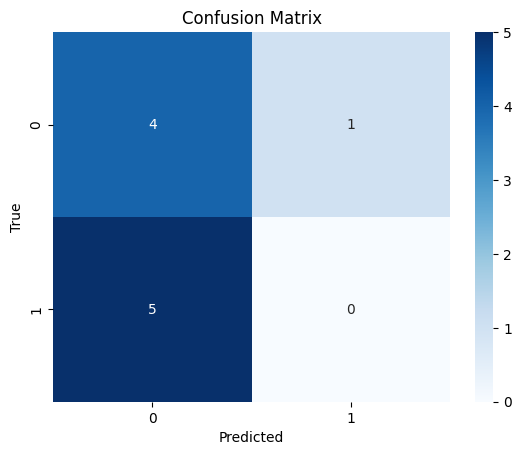

In [41]:
# Set up the device
device = torch.device('cpu')
print(f"Using device: {device}")

# Prepare the data
X_train, X_test, y_train, y_test = prepare_balanced_data(industry_papers, academic_papers)

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

# Create datasets and loaders
train_dataset = PaperDataset(X_train, y_train, tokenizer)
test_dataset = PaperDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Initialize the model
model = SciBertClassifier(num_classes=2)
model.to(device)

# Train the model
model, history = train_scibert_classifier(model, train_loader, test_loader, device, epochs=5)

# Evaluate the model
accuracy, report, conf_matrix = evaluate_scibert_classifier(model, test_loader, device)
print(f"Test Accuracy: {accuracy:.4f}")
print(report)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# WORD FREQUENCY


Academic tokens total: 19,664
Industry tokens total: 10,385


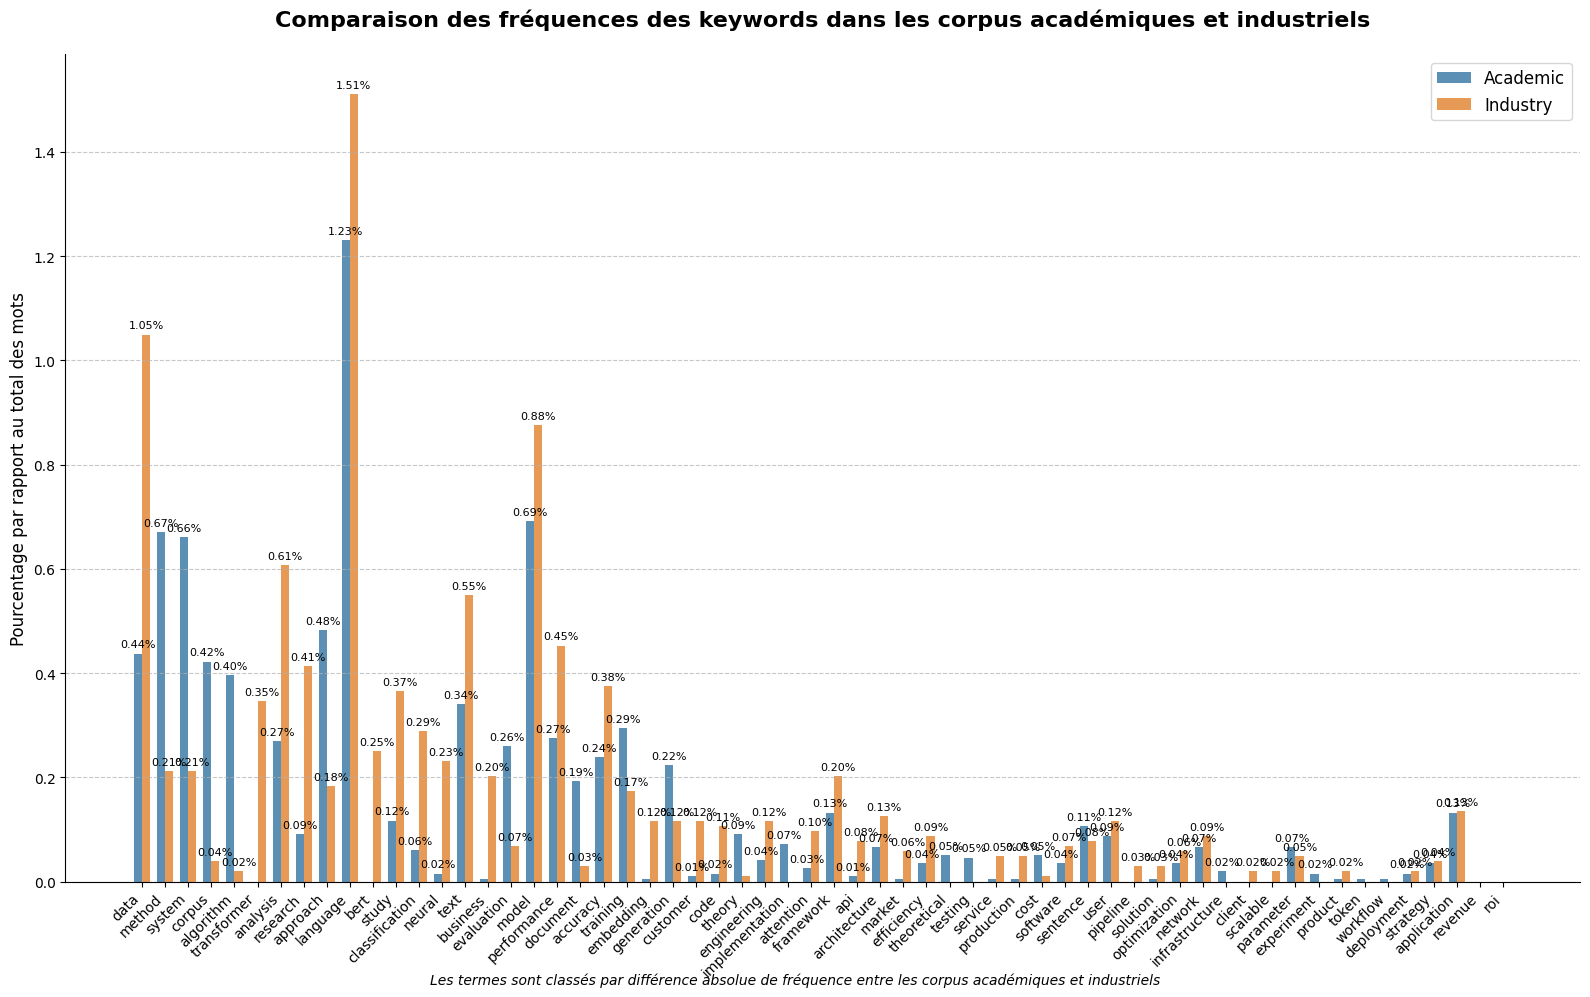


Term Frequency Comparison (% of total words)
Term            | Academic (%)    | Industry (%)    | Ratio (Ind/Acad)     | Diff (Ind-Acad)
-------------------------------------------------------------------------------------
data            | 0.4373          | 1.0496          | 2.40                 | +0.6122        
method          | 0.6713          | 0.2118          | 0.32                 | -0.4594        
system          | 0.6611          | 0.2118          | 0.32                 | -0.4493        
corpus          | 0.4221          | 0.0385          | 0.09                 | -0.3836        
algorithm       | 0.3967          | 0.0193          | 0.05                 | -0.3774        
transformer     | 0.0000          | 0.3467          | inf                  | +0.3467        
analysis        | 0.2695          | 0.6066          | 2.25                 | +0.3371        
research        | 0.0915          | 0.4141          | 4.52                 | +0.3225        
approach        | 0.4831       

In [12]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Create frequency distributions with error handling
def get_term_frequencies(tokens_list):
    try:
        all_tokens = [token for doc_tokens in tokens_list for token in doc_tokens]
        return Counter(all_tokens)
    except Exception as e:
        print(f"Error creating frequency distribution: {e}")
        return Counter()  # Return empty Counter if there's an error

# Safely get frequencies
try:
    academic_freq = get_term_frequencies(academic_tokens)
    industry_freq = get_term_frequencies(industry_tokens)
    
    # Calculate totals
    academic_total = sum(academic_freq.values())
    industry_total = sum(industry_freq.values())
    
    if academic_total == 0 or industry_total == 0:
        raise ValueError("One or both token collections are empty")
        
    print(f"Academic tokens total: {academic_total:,}")
    print(f"Industry tokens total: {industry_total:,}")
    
except Exception as e:
    print(f"Error processing token frequencies: {e}")
    # Create fallback values if needed
    academic_freq = Counter()
    industry_freq = Counter()
    academic_total = 1  # Avoid division by zero
    industry_total = 1  # Avoid division by zero

# Expanded list of key terms
key_terms = [
    # Technical concepts
    "model", "algorithm", "data", "neural", "network", "training", "testing", 
    "evaluation", "accuracy", "performance", "optimization", "parameter",
    
    # Research vs. practical focus
    "theory", "theoretical", "research", "experiment", "study", "analysis",
    "application", "deployment", "implementation", "solution", "system", 
    
    # User/customer focus
    "user", "customer", "client", "product", "service", "market", "business",
    
    # NLP-specific terms
    "language", "text", "transformer", "bert", "attention", "embedding", 
    "token", "sentence", "document", "corpus", "classification", "generation",
    
    # Process terms
    "method", "framework", "approach", "strategy", "pipeline", "workflow",
    
    # Development terms
    "code", "software", "engineering", "architecture", "infrastructure", "api",
    
    # Business value terms
    "cost", "efficiency", "scalable", "production", "revenue", "roi"
]

# Calculate relative frequencies (percentage of total words) with error handling
def safe_get_frequency(freq_dict, term, total):
    try:
        return (freq_dict.get(term, 0) / total * 100)
    except (ZeroDivisionError, TypeError):
        return 0

academic_relative = {term: safe_get_frequency(academic_freq, term, academic_total) for term in key_terms}
industry_relative = {term: safe_get_frequency(industry_freq, term, industry_total) for term in key_terms}

# Sort terms by the absolute difference between academic and industry frequencies
def get_difference(term):
    return abs(academic_relative.get(term, 0) - industry_relative.get(term, 0))

sorted_terms = sorted(key_terms, key=get_difference, reverse=True)

# Create the bar chart with error handling
try:
    fig, ax = plt.subplots(figsize=(16, 10))

    x = np.arange(len(sorted_terms))
    width = 0.35

    rects1 = ax.bar(x - width/2, [academic_relative.get(term, 0) for term in sorted_terms], 
                   width, label='Academic', color='#3274A1', alpha=0.8)
    rects2 = ax.bar(x + width/2, [industry_relative.get(term, 0) for term in sorted_terms], 
                   width, label='Industry', color='#E1812C', alpha=0.8)

    # Add value labels on top of the bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            if height > 0.01:  # Only label bars with visible values
                ax.annotate(f'{height:.2f}%',
                           xy=(rect.get_x() + rect.get_width() / 2, height),
                           xytext=(0, 3),  # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom',
                           fontsize=8)

    autolabel(rects1)
    autolabel(rects2)

    # Add visual elements
    ax.set_ylabel('Pourcentage par rapport au total des mots', fontsize=12)
    ax.set_title('Comparaison des fréquences des keywords dans les corpus académiques et industriels', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(sorted_terms, rotation=45, ha='right', fontsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(fontsize=12)
    
    # Add gridlines for better readability
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    
    # Add text explaining the sorting
    plt.figtext(0.5, 0.01, 
               "Les termes sont classés par différence absolue de fréquence entre les corpus académiques et industriels",
               ha="center", fontsize=10, style='italic')

    fig.tight_layout()
    
    # Save with error handling
    try:
        plt.savefig("term_frequency_comparison.png", dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"Error saving figure: {e}")
        
    plt.show()

except Exception as e:
    print(f"Error creating bar chart: {e}")

# Print the actual values with error handling
try:
    print("\nTerm Frequency Comparison (% of total words)")
    print(f"{'Term':<15} | {'Academic (%)':<15} | {'Industry (%)':<15} | {'Ratio (Ind/Acad)':<20} | {'Diff (Ind-Acad)':<15}")
    print("-" * 85)

    for term in sorted_terms:
        acad_val = academic_relative.get(term, 0)
        ind_val = industry_relative.get(term, 0)
        
        # Calculate ratio with error handling
        try:
            if acad_val > 0:
                ratio = ind_val / acad_val
            else:
                ratio = float('inf') if ind_val > 0 else 0
        except Exception:
            ratio = float('nan')
            
        # Calculate absolute difference
        diff = ind_val - acad_val
        
        print(f"{term:<15} | {acad_val:<15.4f} | {ind_val:<15.4f} | {ratio:<20.2f} | {diff:<+15.4f}")

    # Generate summary statistics
    highest_academic = max(key_terms, key=lambda t: academic_relative.get(t, 0))
    highest_industry = max(key_terms, key=lambda t: industry_relative.get(t, 0))
    
    biggest_diff_academic = max(key_terms, key=lambda t: academic_relative.get(t, 0) - industry_relative.get(t, 0))
    biggest_diff_industry = max(key_terms, key=lambda t: industry_relative.get(t, 0) - academic_relative.get(t, 0))
    
    print("\nSummary:")
    print(f"Most frequent academic term: '{highest_academic}' ({academic_relative.get(highest_academic, 0):.4f}%)")
    print(f"Most frequent industry term: '{highest_industry}' ({industry_relative.get(highest_industry, 0):.4f}%)")
    print(f"Biggest difference favoring academic: '{biggest_diff_academic}' " +
          f"(Diff: {academic_relative.get(biggest_diff_academic, 0) - industry_relative.get(biggest_diff_academic, 0):.4f}%)")
    print(f"Biggest difference favoring industry: '{biggest_diff_industry}' " +
          f"(Diff: {industry_relative.get(biggest_diff_industry, 0) - academic_relative.get(biggest_diff_industry, 0):.4f}%)")

except Exception as e:
    print(f"Error printing term frequency comparison: {e}")

# Word Cluster Analysis

/var/folders/j0/n1zmwvf923q5h9v_4n2k33100000gn/T/ipykernel_30240/427016927.py:56: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/j0/n1zmwvf923q5h9v_4n2k33100000gn/T/ipykernel_30240/427016927.py:56: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Academic Clusters:
Cluster 5 (word): word, different, results, information, work, translation, also, two, tasks, performance
Cluster 2 (datasets): datasets, future, dataset, evaluation, networks, however, semantic, abstract, show, nlp
Cluster 6 (existing): existing, compared, corpus, current, explore, improve, prediction, without, english, available
Cluster 3 (challenging): challenging, layer, bleu, improvements, generate, field, users, loss, query, development
Cluster 4 (formulation): formulation, fingerspelling, containing, contains, feedback, obtain, intermediate, endangered, require, fully
Cluster 1 (fasttext): fasttext, approximates, multi, factor, patient, cognates, quotation, overfitting, enough, put

Industry Clusters:
Cluster 6 (thus): thus, reasonable, advances, conclusion, research, several, quality, transformer, communication, various
Cluster 5 (phase): phase, strong, mask, module, texts, associated, together, others, synthetic, always
Cluster 2 (hence): hence, plain, funct

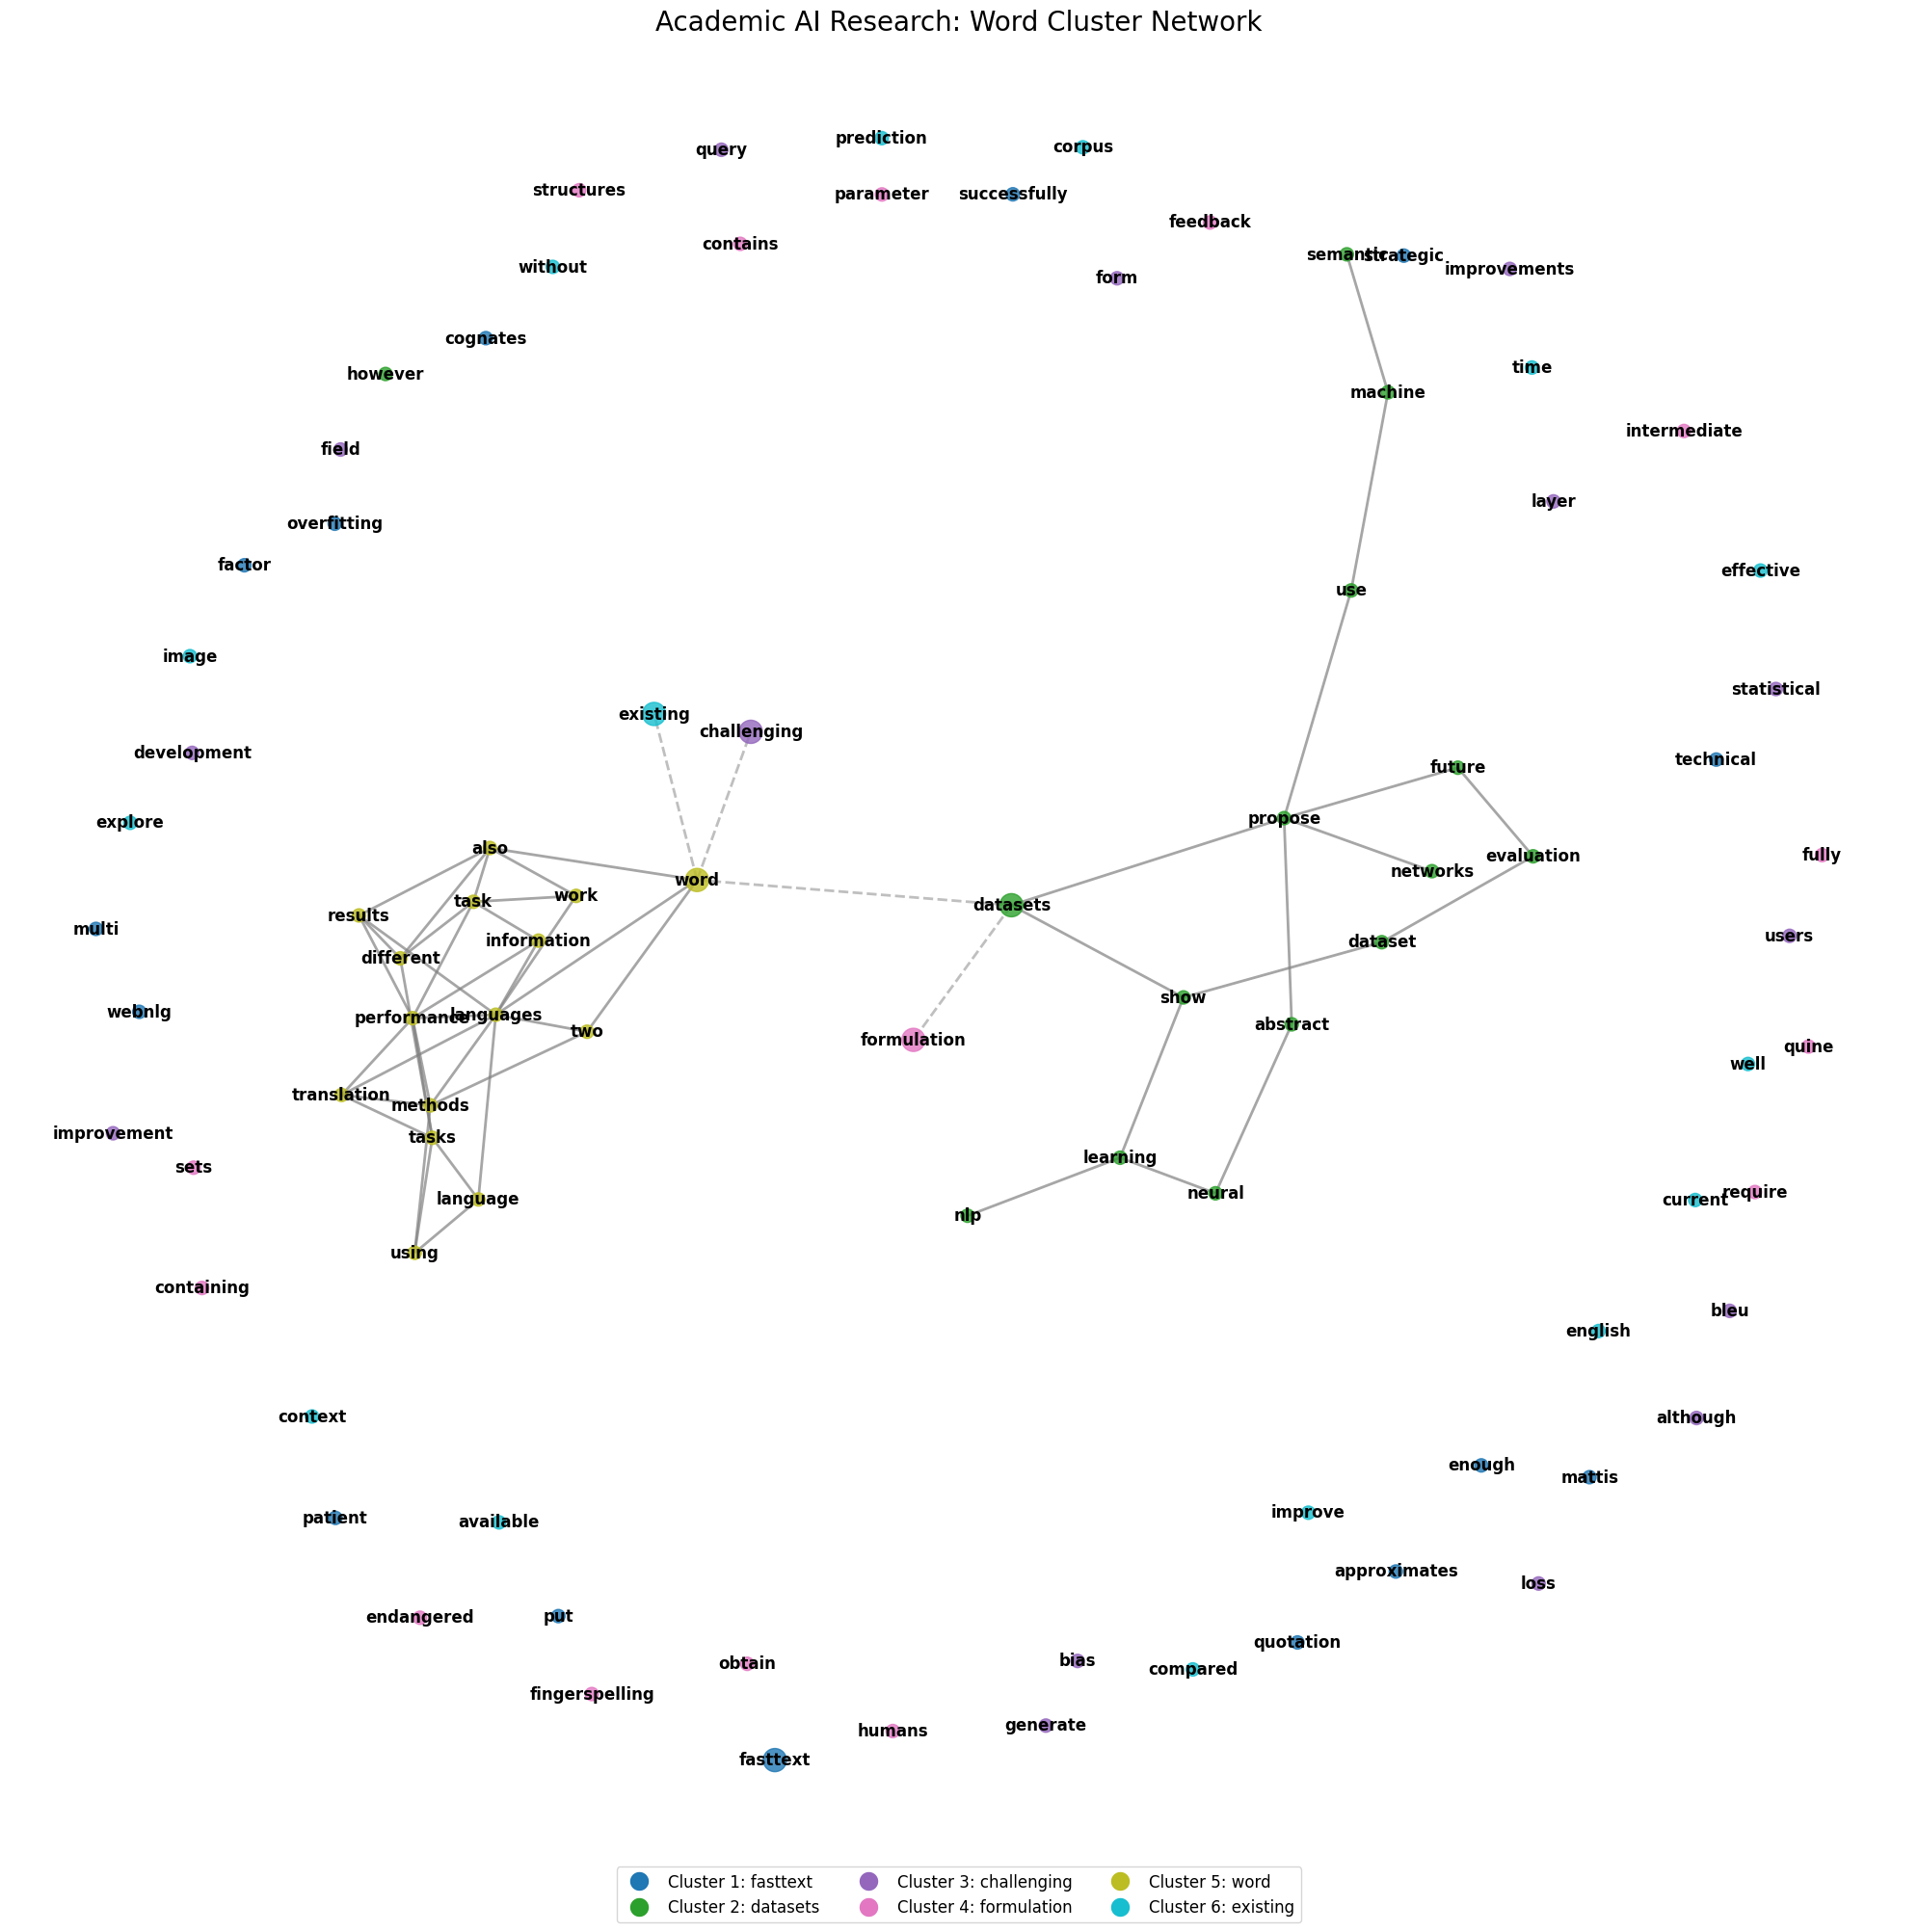

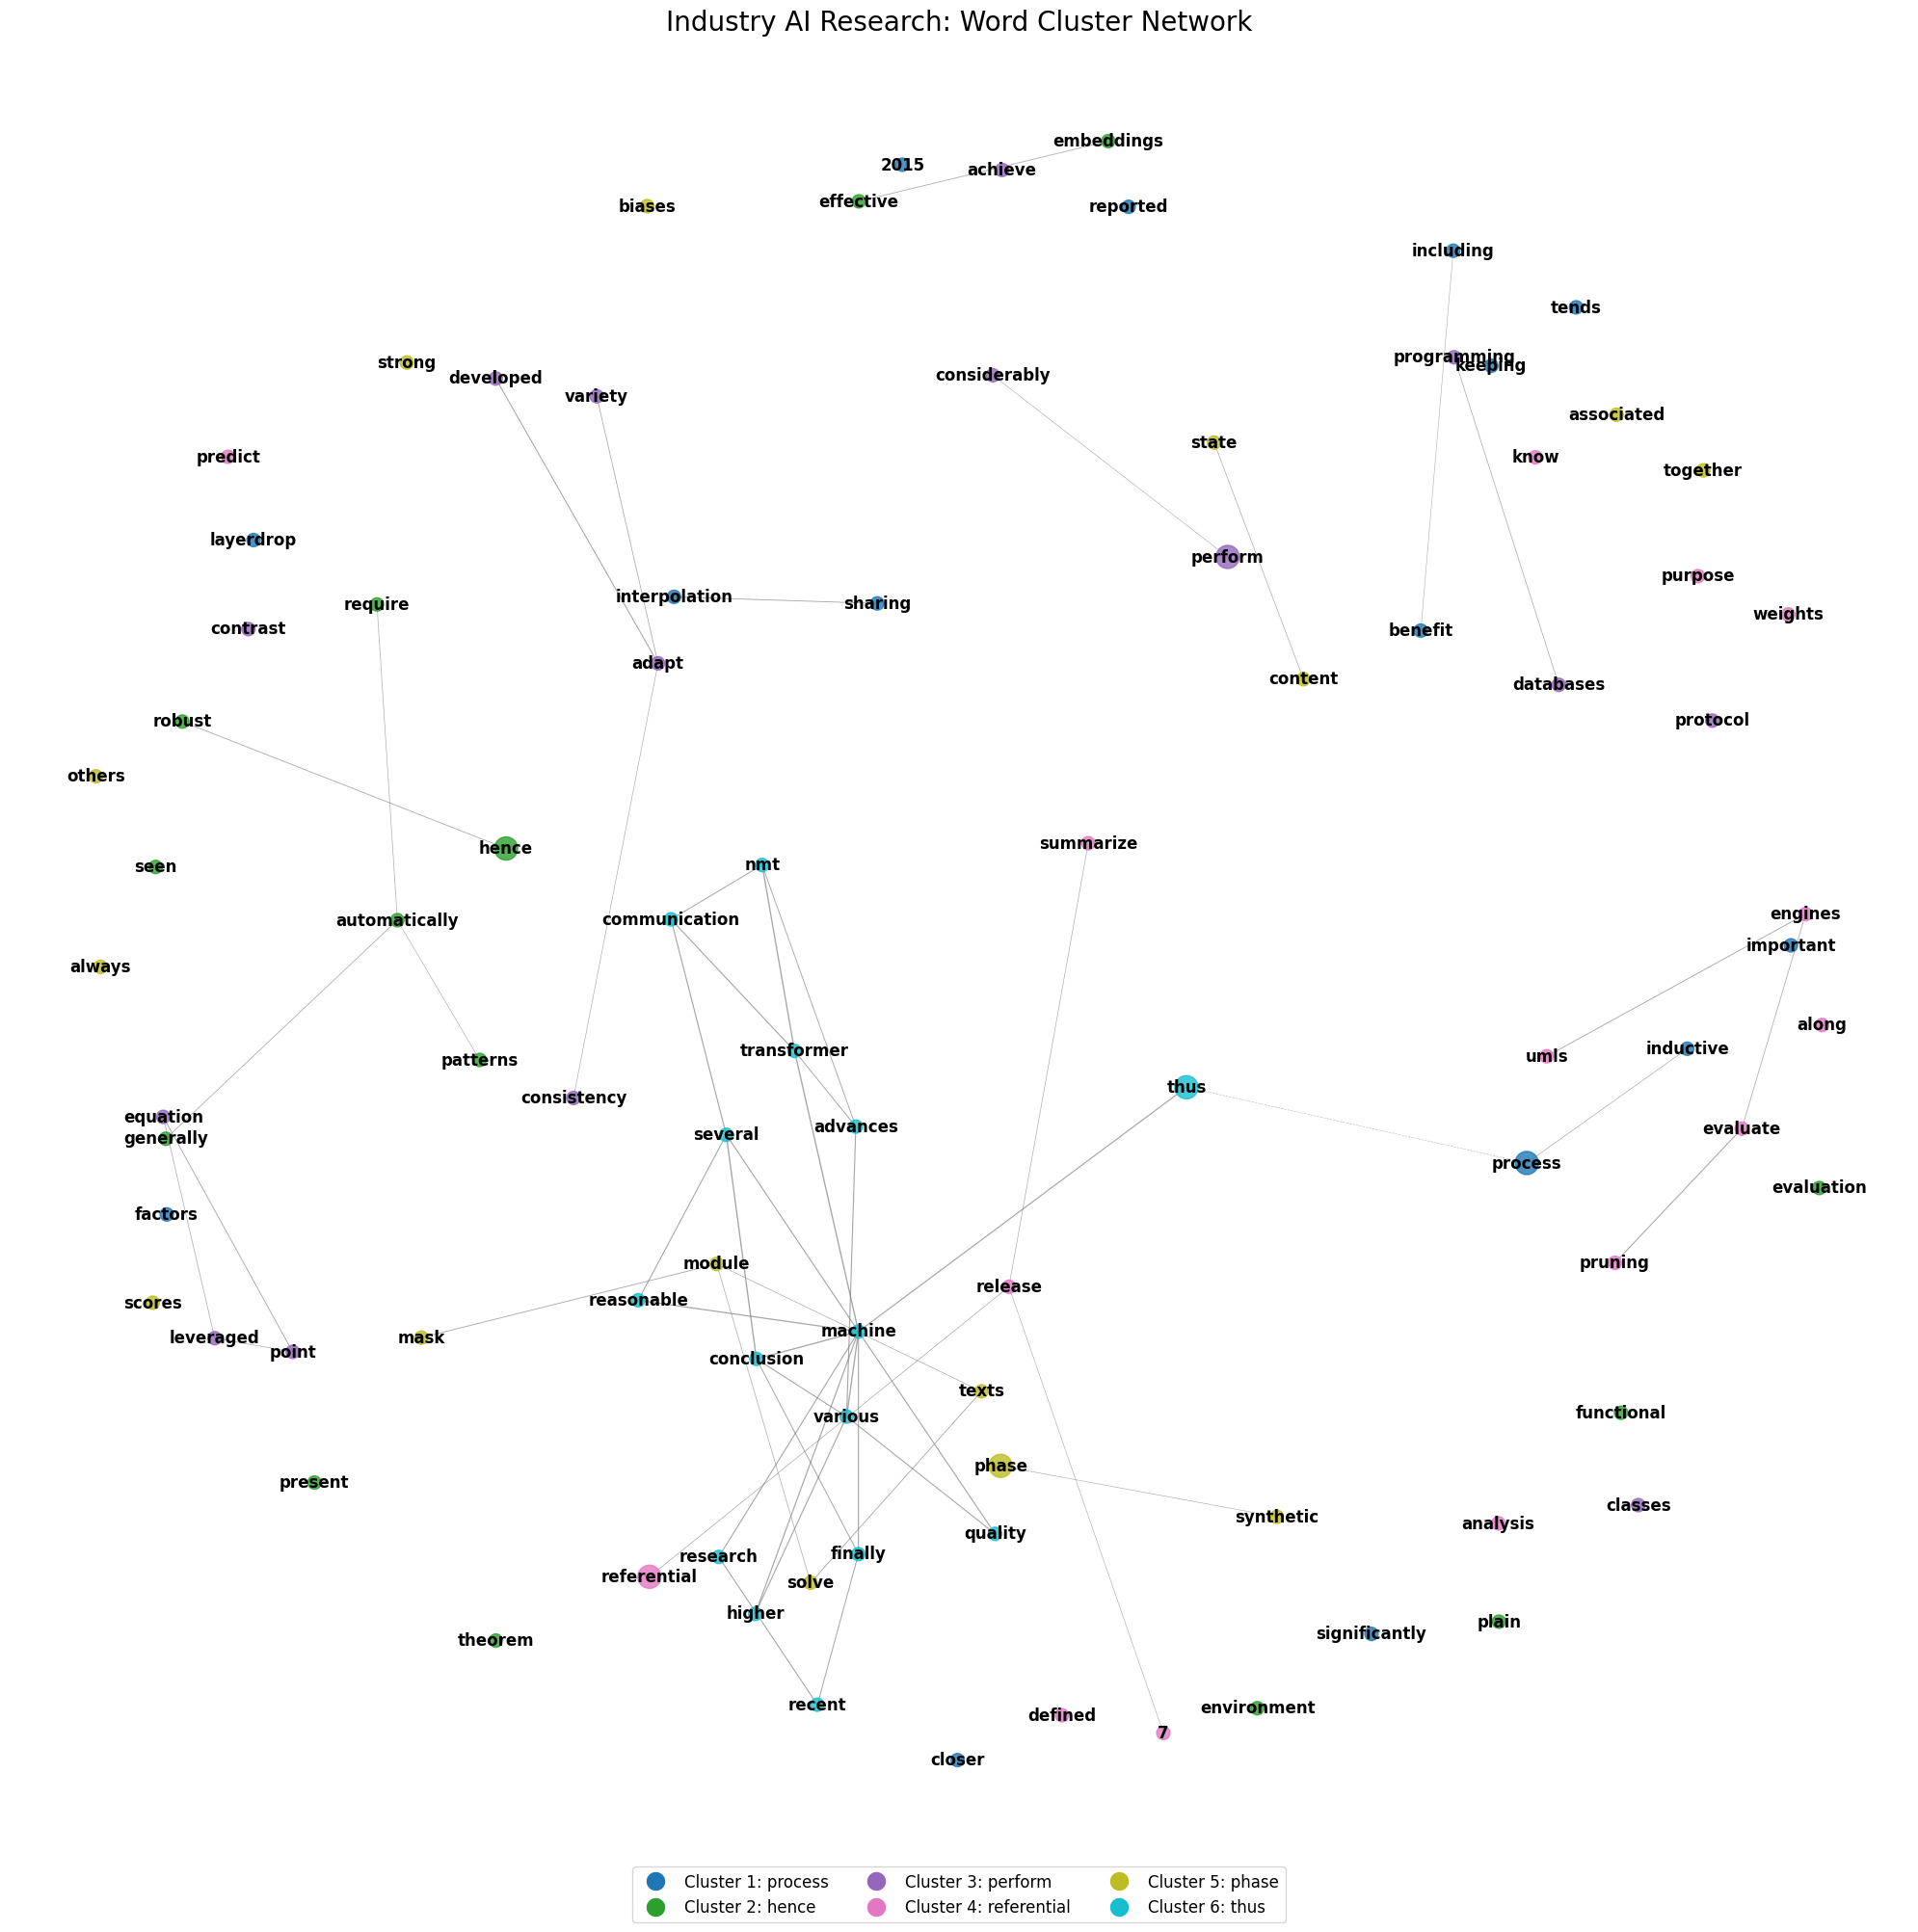

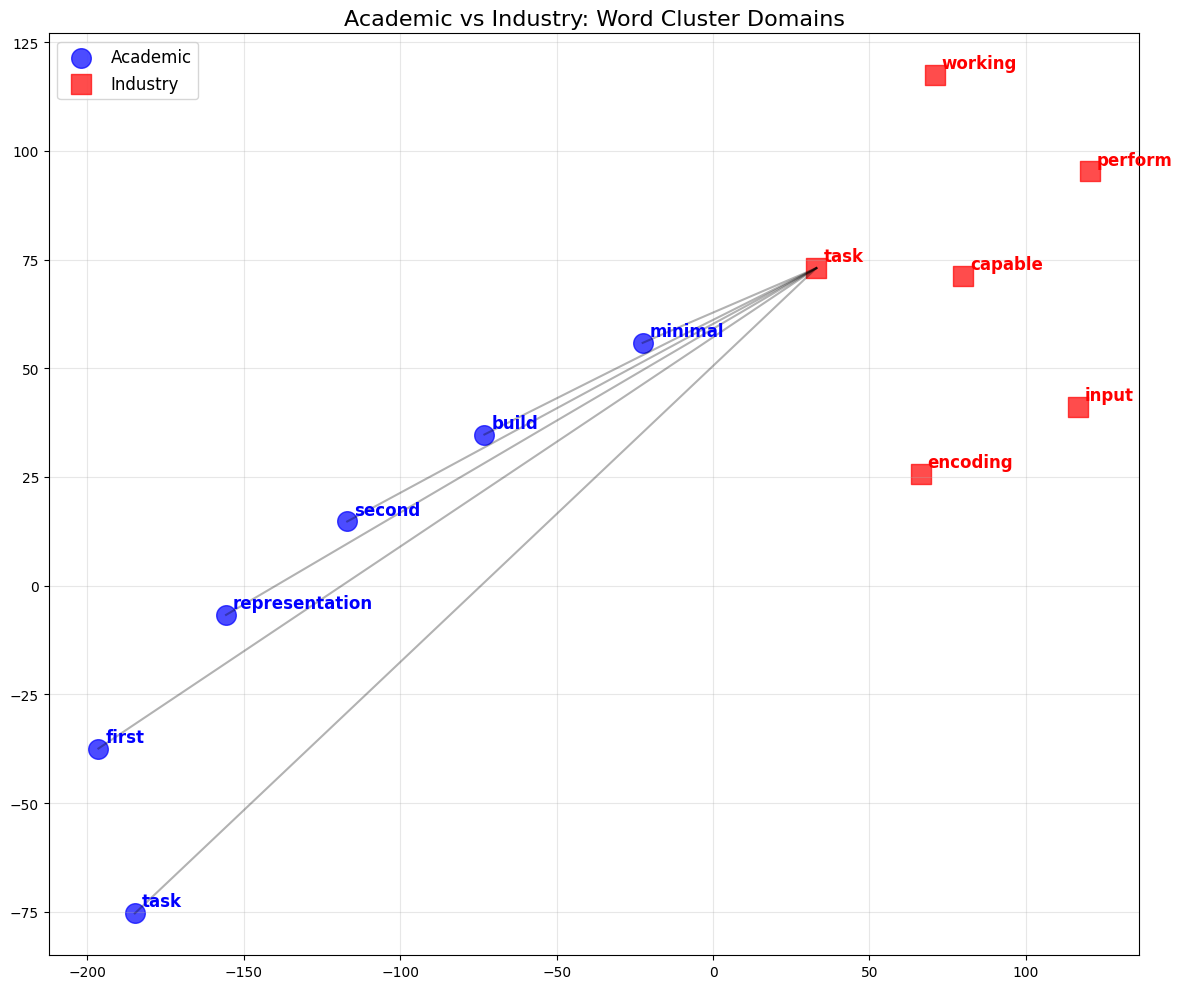

NameError: name 'TSNE' is not defined

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans
import numpy as np
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors

def create_cluster_network_visualization(model, n_clusters=5, n_words_per_cluster=15, top_connections=3, 
                                        title="Word Cluster Network", filename="cluster_network.png"):
    """
    Create a network visualization of word clusters.
    
    Parameters:
    - model: Word2Vec model
    - n_clusters: Number of clusters to identify
    - n_words_per_cluster: Number of words to include from each cluster
    - top_connections: Number of connections to show for each word
    - title: Title for the visualization
    - filename: Output filename for saving the figure
    """
    # Get all word vectors from the model
    words = list(model.wv.index_to_key)
    word_vectors = [model.wv[word] for word in words]
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(word_vectors)
    
    # Organize words by cluster
    cluster_words = {}
    for i, word in enumerate(words):
        cluster_id = clusters[i]
        if cluster_id not in cluster_words:
            cluster_words[cluster_id] = []
        cluster_words[cluster_id].append((word, model.wv.get_vector(word)))
    
    # Get the most central words in each cluster
    top_cluster_words = {}
    for cluster_id, word_vectors in cluster_words.items():
        # Calculate distance to cluster center
        cluster_center = kmeans.cluster_centers_[cluster_id]
        distances = []
        
        for word, vector in word_vectors:
            distance = np.linalg.norm(vector - cluster_center)
            distances.append((word, distance))
        
        # Sort by distance to center
        sorted_words = sorted(distances, key=lambda x: x[1])
        top_cluster_words[cluster_id] = [word for word, _ in sorted_words[:n_words_per_cluster]]
    
    # Create a graph
    G = nx.Graph()
    
    # Define a colormap with distinct colors for each cluster
    cmap = plt.cm.get_cmap('tab10', n_clusters)
    
    # Add nodes with cluster information
    for cluster_id, words in top_cluster_words.items():
        color = mcolors.rgb2hex(cmap(cluster_id))
        
        # Find the central word of the cluster (closest to cluster center)
        central_word = words[0]
        
        # Mark the central word as the cluster representative
        G.add_node(central_word, cluster=cluster_id, color=color, size=300, is_central=True)
        
        # Add the rest of the top words in the cluster
        for word in words[1:]:
            G.add_node(word, cluster=cluster_id, color=color, size=100, is_central=False)
    
    # Add edges between related words
    added_edges = set()
    for cluster_id, words in top_cluster_words.items():
        for word in words:
            # Find the most similar words within the same cluster
            if word in model.wv:
                similar_words = [(w, s) for w, s in model.wv.most_similar(word, topn=20) 
                                if w in G.nodes() and G.nodes[w]['cluster'] == cluster_id]
                
                # Add edges for top connections
                for similar_word, similarity in similar_words[:top_connections]:
                    # Avoid duplicate edges
                    edge_key = tuple(sorted([word, similar_word]))
                    if edge_key not in added_edges:
                        G.add_edge(word, similar_word, weight=similarity)
                        added_edges.add(edge_key)
    
    # Add some inter-cluster connections based on similarity
    for cluster_id, words in top_cluster_words.items():
        central_word = words[0]
        if central_word in model.wv:
            similar_words = [(w, s) for w, s in model.wv.most_similar(central_word, topn=30) 
                            if w in G.nodes() and G.nodes[w]['cluster'] != cluster_id and G.nodes[w]['is_central']]
            
            # Add a few cross-cluster connections
            for similar_word, similarity in similar_words[:2]:
                edge_key = tuple(sorted([central_word, similar_word]))
                if edge_key not in added_edges:
                    G.add_edge(central_word, similar_word, weight=similarity, style='dashed')
                    added_edges.add(edge_key)
    
    # Set up the plot
    plt.figure(figsize=(20, 20))
    
    # Use force-directed layout
    pos = nx.spring_layout(G, k=0.3, iterations=50)
    
    # Draw nodes for each cluster
    for cluster_id in range(n_clusters):
        # Get nodes for this cluster
        cluster_nodes = [node for node, attr in G.nodes(data=True) if attr.get('cluster') == cluster_id]
        
        # Get node sizes
        node_sizes = [G.nodes[node]['size'] for node in cluster_nodes]
        
        # Draw the nodes
        nx.draw_networkx_nodes(G, pos, 
                             nodelist=cluster_nodes,
                             node_size=node_sizes,
                             node_color=[G.nodes[node]['color'] for node in cluster_nodes],
                             alpha=0.8)
    
    # Draw edges with varying thickness based on similarity
    for u, v, data in G.edges(data=True):
        if data.get('style') == 'dashed':
            # Inter-cluster edges (dashed)
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=data['weight'] * 2, 
                                 alpha=0.5, style='dashed', edge_color='grey')
        else:
            # Intra-cluster edges (solid)
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=data['weight'] * 2, 
                                 alpha=0.7, edge_color='grey')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    
    # Create a legend for clusters
    handles = []
    for cluster_id in range(n_clusters):
        color = mcolors.rgb2hex(cmap(cluster_id))
        central_word = top_cluster_words[cluster_id][0]
        label = f"Cluster {cluster_id+1}: {central_word}"
        handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                          markersize=15, label=label)
        handles.append(handle)
    
    # Add the legend
    plt.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.05), 
             ncol=3, fontsize=12)
    
    plt.axis('off')
    plt.title(title, fontsize=20, pad=20)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    return G, top_cluster_words

# Create visualizations for both models
academic_graph, academic_clusters = create_cluster_network_visualization(
    academic_model, 
    n_clusters=6, 
    title="Academic AI Research: Word Cluster Network",
    filename="academic_cluster_network.png"
)

industry_graph, industry_clusters = create_cluster_network_visualization(
    industry_model, 
    n_clusters=6, 
    title="Industry AI Research: Word Cluster Network",
    filename="industry_cluster_network.png"
)

# Print cluster summaries
print("Academic Clusters:")
for cluster_id, words in academic_clusters.items():
    central_word = words[0]
    print(f"Cluster {cluster_id+1} ({central_word}): {', '.join(words[:10])}")

print("\nIndustry Clusters:")
for cluster_id, words in industry_clusters.items():
    central_word = words[0]
    print(f"Cluster {cluster_id+1} ({central_word}): {', '.join(words[:10])}")



# Semantic Diff Analysis

Calculating semantic differentials...
Visualization saved as 'semantic_differential.png'


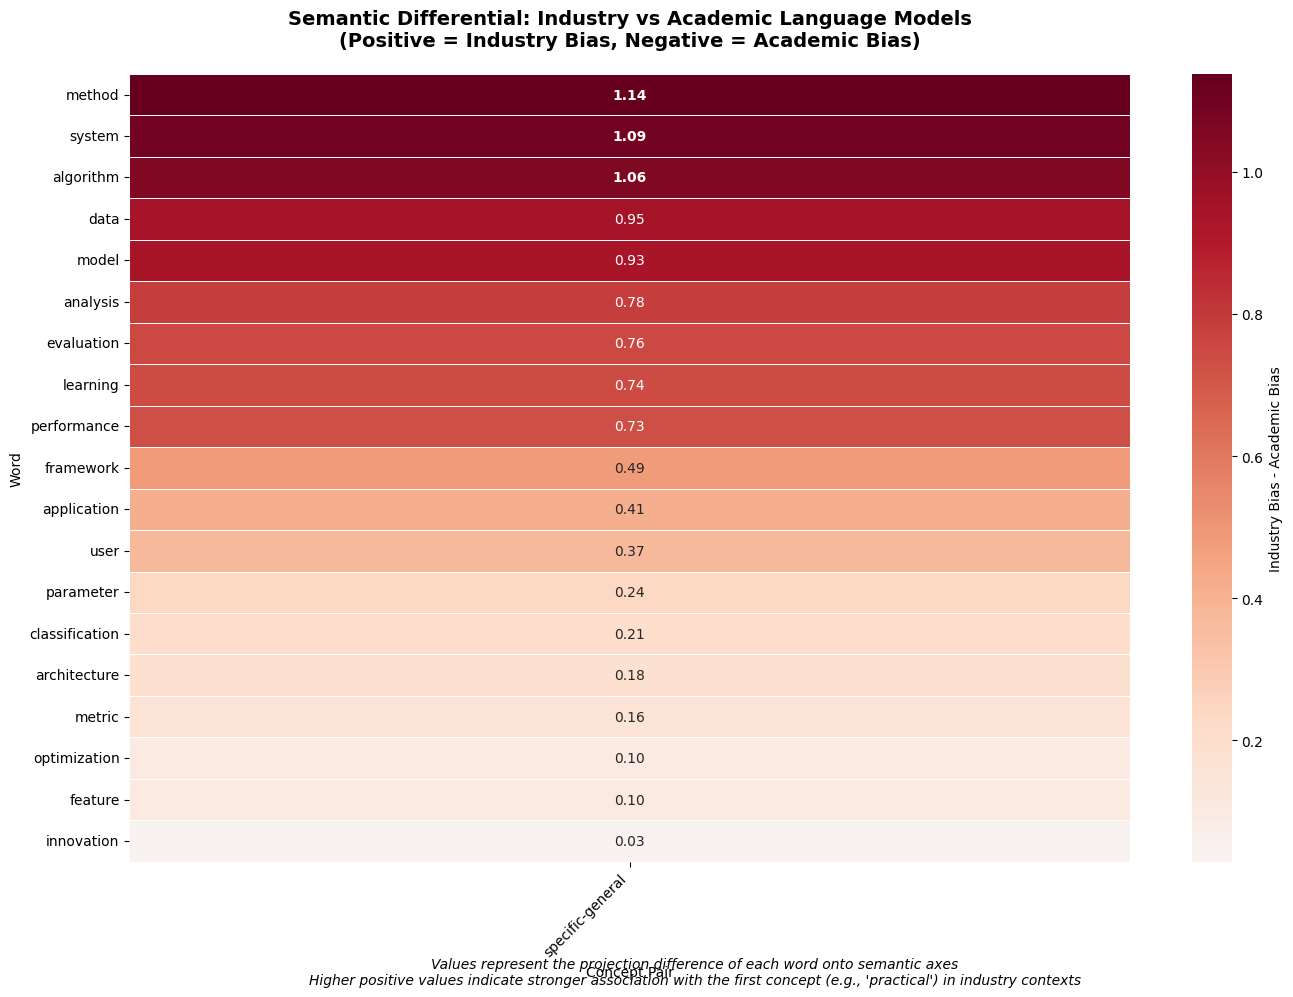


Summary of Strongest Semantic Differentials:
----------------------------------------------------------------------
method          | Strongest industry bias: specific-general     (1.14)
                | Strongest academic bias: specific-general     (1.14)
----------------------------------------------------------------------
system          | Strongest industry bias: specific-general     (1.09)
                | Strongest academic bias: specific-general     (1.09)
----------------------------------------------------------------------
algorithm       | Strongest industry bias: specific-general     (1.06)
                | Strongest academic bias: specific-general     (1.06)
----------------------------------------------------------------------
data            | Strongest industry bias: specific-general     (0.95)
                | Strongest academic bias: specific-general     (0.95)
----------------------------------------------------------------------
model           | Strongest ind

In [13]:
def semantic_differential(academic_model, industry_model, concept_pairs, test_words):
    """
    Calculate semantic differential between academic and industry models
    with comprehensive error handling
    """
    results = {}
    
    for test_word in test_words:
        # Skip words not in both models' vocabularies
        try:
            if test_word not in academic_model.wv or test_word not in industry_model.wv:
                print(f"Warning: '{test_word}' not found in both vocabularies. Skipping.")
                continue
                
            word_results = {}
            
            for concept1, concept2 in concept_pairs:
                # Verify all concept words exist in both vocabularies
                if not all(word in academic_model.wv for word in [concept1, concept2]):
                    print(f"Warning: Concept pair '{concept1}-{concept2}' missing from academic vocabulary. Skipping.")
                    continue
                    
                if not all(word in industry_model.wv for word in [concept1, concept2]):
                    print(f"Warning: Concept pair '{concept1}-{concept2}' missing from industry vocabulary. Skipping.")
                    continue
                
                try:
                    # Calculate the concept differential vector
                    academic_diff = academic_model.wv[concept1] - academic_model.wv[concept2]
                    industry_diff = industry_model.wv[concept1] - industry_model.wv[concept2]
                    
                    # Check for zero vectors
                    academic_norm = np.linalg.norm(academic_diff)
                    industry_norm = np.linalg.norm(industry_diff)
                    
                    if academic_norm < 1e-10 or industry_norm < 1e-10:
                        print(f"Warning: Near-zero differential for '{concept1}-{concept2}'. Skipping.")
                        continue
                    
                    # Project the test word onto the differential
                    academic_projection = np.dot(academic_model.wv[test_word], academic_diff) / academic_norm
                    industry_projection = np.dot(industry_model.wv[test_word], industry_diff) / industry_norm
                    
                    word_results[f"{concept1}-{concept2}"] = {
                        "academic": float(academic_projection),  # Convert numpy types to Python native types
                        "industry": float(industry_projection),
                        "difference": float(industry_projection - academic_projection)
                    }
                except Exception as e:
                    print(f"Error calculating differential for '{test_word}' on '{concept1}-{concept2}': {e}")
            
            # Only add results if we have at least one valid concept pair
            if word_results:
                results[test_word] = word_results
                
        except Exception as e:
            print(f"Error processing test word '{test_word}': {e}")
    
    # Check if we have any results
    if not results:
        print("Warning: No valid results to return. Check if vocabularies contain the specified words.")
        
    return results

# Define concept pairs for the differential
concept_pairs = [
    ("practical", "theoretical"),
    ("product", "research"),
    ("business", "academic"),
    ("concrete", "abstract"),
    ("specific", "general"),
    ("customer", "student"),
    ("efficient", "comprehensive"),
    ("implementation", "methodology"),
    ("deployment", "simulation"),
    ("solution", "investigation")
]

# Expanded list of words to analyze
test_words = [
    "algorithm", "model", "learning", "data", "analysis", "system", 
    "performance", "user", "evaluation", "innovation", "transformer",
    "architecture", "feature", "optimization", "embedding", "classification",
    "framework", "application", "method", "benchmark", "parameter", "metric"
]

# Safely perform the analysis
try:
    print("Calculating semantic differentials...")
    diff_results = semantic_differential(academic_model, industry_model, concept_pairs, test_words)
    
    # Check if we got any results
    if not diff_results:
        raise ValueError("No valid results were obtained from semantic differential analysis")
        
    # Create a visualization
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    
    # Prepare data for plotting with error handling
    plot_data = []
    for word, results in diff_results.items():
        for concept_pair, values in results.items():
            try:
                plot_data.append({
                    "Word": word,
                    "Concept Pair": concept_pair,
                    "Academic": values["academic"],
                    "Industry": values["industry"],
                    "Difference": values["difference"]
                })
            except Exception as e:
                print(f"Error adding data point for {word}/{concept_pair}: {e}")
    
    # Check if we have any data to plot
    if not plot_data:
        raise ValueError("No valid data points for visualization")
        
    df = pd.DataFrame(plot_data)
    
    # Plot the differences
    plt.figure(figsize=(14, 10))
    
    try:
        # Create a pivot table with error handling
        pivot_df = df.pivot(index="Word", columns="Concept Pair", values="Difference")
        
        # Ensure we have values to plot
        if pivot_df.empty:
            raise ValueError("Pivot table is empty")
            
        # Sort rows and columns based on overall patterns for better visualization
        # Sort rows by average difference value
        row_means = pivot_df.mean(axis=1).sort_values(ascending=False)
        sorted_rows = row_means.index.tolist()
        
        # Sort columns by average difference value
        col_means = pivot_df.mean(axis=0).sort_values(ascending=False)
        sorted_cols = col_means.index.tolist()
        
        # Reorder the pivot table
        pivot_df = pivot_df.loc[sorted_rows, sorted_cols]
        
        # Plot with better formatting
        ax = sns.heatmap(
            pivot_df, 
            annot=True,
            cmap="RdBu_r",
            center=0, 
            fmt=".2f",
            linewidths=0.5,
            cbar_kws={'label': 'Industry Bias - Academic Bias'}
        )
        
        # Improve readability of annotations
        for text in ax.texts:
            # Highlight strong differences
            value = float(text.get_text())
            if abs(value) >= 1.0:
                text.set_weight('bold')
            # Set color based on background
            if abs(value) >= 0.5:
                text.set_color('white')
                
        plt.title("Semantic Differential: Industry vs Academic Language Models\n(Positive = Industry Bias, Negative = Academic Bias)", 
                 fontsize=14, fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        
        # Add explanatory text
        plt.figtext(0.5, 0.01, 
                  "Values represent the projection difference of each word onto semantic axes\n"
                  "Higher positive values indicate stronger association with the first concept (e.g., 'practical') in industry contexts",
                  ha='center', fontsize=10, style='italic')
        
        plt.tight_layout()
        
        # Safely save the figure
        try:
            plt.savefig("semantic_differential.png", dpi=300, bbox_inches='tight')
            print("Visualization saved as 'semantic_differential.png'")
        except Exception as e:
            print(f"Error saving figure: {e}")
            
        plt.show()
        
        # Print summary statistics
        print("\nSummary of Strongest Semantic Differentials:")
        print("-" * 70)
        
        # Get strongest industry and academic biases for each word
        for word in sorted_rows:
            word_data = pivot_df.loc[word]
            max_industry = word_data.max()
            min_academic = word_data.min()
            max_concept = word_data.idxmax()
            min_concept = word_data.idxmin()
            
            print(f"{word:15} | Strongest industry bias: {max_concept:20} ({max_industry:.2f})")
            print(f"{' ':15} | Strongest academic bias: {min_concept:20} ({min_academic:.2f})")
            print("-" * 70)
            
    except Exception as e:
        print(f"Error creating heatmap visualization: {e}")
        
        # Fallback visualization if pivot fails
        try:
            plt.figure(figsize=(12, 8))
            
            # Alternative: grouped bar plot
            words = sorted(set(item["Word"] for item in plot_data))
            concept_pairs = sorted(set(item["Concept Pair"] for item in plot_data))
            
            for i, word in enumerate(words[:10]):  # Limit to first 10 words
                word_data = [item for item in plot_data if item["Word"] == word]
                x = np.arange(len(word_data))
                plt.bar(x, [d["Difference"] for d in word_data])
                plt.xticks(x, [d["Concept Pair"] for d in word_data], rotation=45, ha='right')
                plt.title(f"Semantic Differential for '{word}'")
                plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
                plt.tight_layout()
                plt.show()
                
        except Exception as e2:
            print(f"Error creating fallback visualization: {e2}")
            
except Exception as e:
    print(f"Error in semantic differential analysis: {e}")
    print("Detailed error information:")
    import traceback
    traceback.print_exc()

# Model Analogy

In [15]:
def test_analogies(model, analogy_pairs):
    results = []
    
    for a, b, c in analogy_pairs:
        if a in model.wv and b in model.wv and c in model.wv:
            try:
                analogies = model.wv.most_similar(positive=[b, c], negative=[a], topn=3)
                results.append((f"{a} : {b} :: {c} : ?", analogies))
            except:
                results.append((f"{a} : {b} :: {c} : ?", "Could not compute"))
        else:
            results.append((f"{a} : {b} :: {c} : ?", "Terms not in vocabulary"))
    
    return results

# Define analogy triplets to test (a:b::c:?)
analogy_pairs = [
    ("model", "prediction", "algorithm"),
    ("research", "paper", "product"),
    ("data", "feature", "user"),
    ("learning", "knowledge", "optimization"),
    ("theory", "concept", "application"),
    ("algorithm", "computation", "model"),
    ("user", "need", "researcher")
]

academic_analogies = test_analogies(academic_model, analogy_pairs)
industry_analogies = test_analogies(industry_model, analogy_pairs)

# Print results
print("Analogy Testing in Academic Domain")
print("-" * 80)
for analogy, results in academic_analogies:
    print(f"Analogy: {analogy}")
    if isinstance(results, list):
        for term, score in results:
            print(f"  {term} (score: {score:.4f})")
    else:
        print(f"  {results}")
    print()

print("\nAnalogy Testing in Industry Domain")
print("-" * 80)
for analogy, results in industry_analogies:
    print(f"Analogy: {analogy}")
    if isinstance(results, list):
        for term, score in results:
            print(f"  {term} (score: {score:.4f})")
    else:
        print(f"  {results}")
    print()

Analogy Testing in Academic Domain
--------------------------------------------------------------------------------
Analogy: model : prediction :: algorithm : ?
  better (score: 0.9984)
  proposed (score: 0.9983)
  methods (score: 0.9983)

Analogy: research : paper :: product : ?
  abstract (score: 0.9984)
  words (score: 0.9983)
  two (score: 0.9983)

Analogy: data : feature :: user : ?
  entity (score: 0.9926)
  previous (score: 0.9926)
  mt (score: 0.9924)

Analogy: learning : knowledge :: optimization : ?
  two (score: 0.9986)
  used (score: 0.9985)
  research (score: 0.9985)

Analogy: theory : concept :: application : ?
  tuning (score: 0.9096)
  computational (score: 0.9091)
  expensive (score: 0.9086)

Analogy: algorithm : computation :: model : ?
  two (score: 0.9953)
  across (score: 0.9953)
  embedding (score: 0.9952)

Analogy: user : need :: researcher : ?
  Terms not in vocabulary


Analogy Testing in Industry Domain
---------------------------------------------------------

# Descriptive Metrics


Comparison of Academic vs Industry Papers:
                            Metric  Academic  Industry  Difference  Percentage
0                 Number of papers    296.00     90.00     -206.00      -69.59
1     Average title length (chars)     63.65     85.77       22.11       34.74
2  Average abstract length (chars)    699.25   1224.20      524.95       75.07
3   Average content length (chars)  45408.15  66045.18    20637.03       45.45
4         Average title word count      8.59     11.94        3.36       39.09
5      Average abstract word count    106.79    182.99       76.20       71.35
6       Average content word count   8106.26  10214.66     2108.40       26.01
7       Average abstract sentences      6.21      9.47        3.25       52.37
8        Average content sentences    579.36   1277.66      698.30      120.53


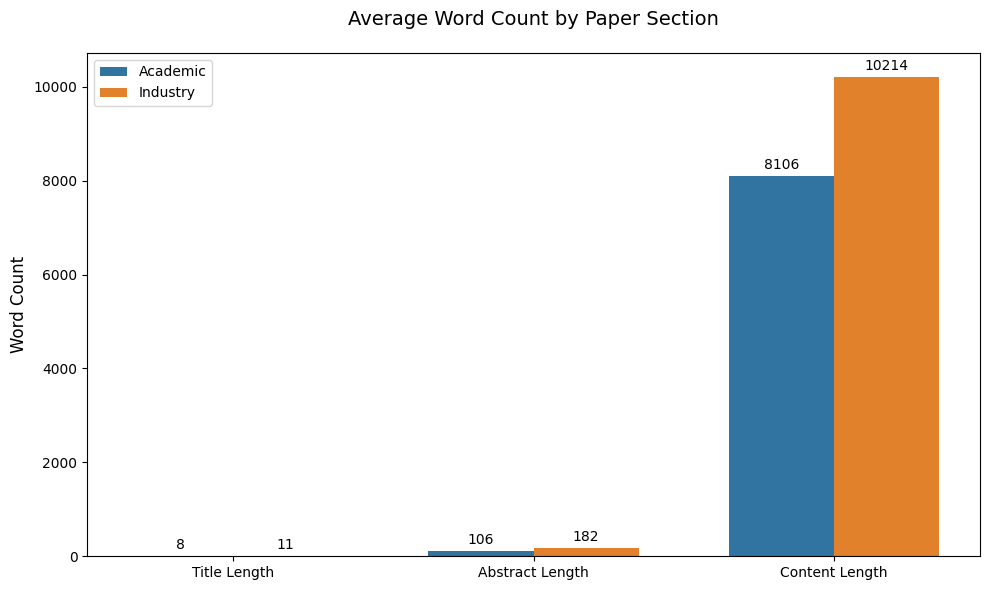

In [15]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Function to extract document section statistics
def extract_section_stats(df, corpus_name="Corpus"):
    """
    Extract statistics about different sections of papers
    
    Parameters:
    - df: DataFrame with paper information
    - corpus_name: Name of the corpus for reporting
    
    Returns:
    - Dictionary of section statistics
    """
    try:
        # Initialize statistics dictionary
        stats = {
            "corpus_name": corpus_name,
            "num_papers": len(df),
            "title_lengths": [],
            "abstract_lengths": [],
            "content_lengths": [],
            "conclusion_lengths": [],
            "title_word_counts": [],
            "abstract_word_counts": [],
            "content_word_counts": [],
            "conclusion_word_counts": [],
            "abstract_sentence_counts": [],
            "content_sentence_counts": [],
            "conclusion_sentence_counts": []
        }
        
        # Process each paper
        for _, paper in df.iterrows():
            # Title statistics
            title = str(paper.get('title', ''))
            stats["title_lengths"].append(len(title))
            stats["title_word_counts"].append(len(re.findall(r'\b\w+\b', title.lower())))
            
            # Abstract statistics
            abstract = str(paper.get('abstract', ''))
            stats["abstract_lengths"].append(len(abstract))
            stats["abstract_word_counts"].append(len(re.findall(r'\b\w+\b', abstract.lower())))
            stats["abstract_sentence_counts"].append(len(re.split(r'[.!?]+', abstract)))
            
            # Content statistics
            content = str(paper.get('content', ''))
            stats["content_lengths"].append(len(content))
            stats["content_word_counts"].append(len(re.findall(r'\b\w+\b', content.lower())))
            stats["content_sentence_counts"].append(len(re.split(r'[.!?]+', content)))
        
        # Calculate summary statistics for each metric - using a list of keys to avoid dictionary modification during iteration
        metrics_to_summarize = [k for k in stats.keys() if isinstance(stats[k], list) and stats[k]]
        
        for metric in metrics_to_summarize:
            stats[f"{metric}_mean"] = np.mean(stats[metric])
            stats[f"{metric}_median"] = np.median(stats[metric])
            stats[f"{metric}_std"] = np.std(stats[metric])
                
        return stats
        
    except Exception as e:
        print(f"Error extracting section stats for {corpus_name}: {e}")
        import traceback
        traceback.print_exc()
        return {"num_papers": 0}  # Return minimal dictionary with num_papers to prevent KeyError

# Extract statistics for both academic and industry papers
academic_stats = extract_section_stats(academic_papers, "Academic")
industry_stats = extract_section_stats(industry_papers, "Industry")

# Compare key metrics between the two corpora
comparison = pd.DataFrame({
    'Metric': [
        'Number of papers',
        'Average title length (chars)',
        'Average abstract length (chars)',
        'Average content length (chars)',
        'Average title word count',
        'Average abstract word count',
        'Average content word count',
        'Average abstract sentences',
        'Average content sentences'
    ],
    'Academic': [
        academic_stats.get('num_papers', 0),
        academic_stats.get('title_lengths_mean', 0),
        academic_stats.get('abstract_lengths_mean', 0),
        academic_stats.get('content_lengths_mean', 0),
        academic_stats.get('title_word_counts_mean', 0),
        academic_stats.get('abstract_word_counts_mean', 0),
        academic_stats.get('content_word_counts_mean', 0),
        academic_stats.get('abstract_sentence_counts_mean', 0),
        academic_stats.get('content_sentence_counts_mean', 0),
        
    ],
    'Industry': [
        industry_stats.get('num_papers', 0),
        industry_stats.get('title_lengths_mean', 0),
        industry_stats.get('abstract_lengths_mean', 0),
        industry_stats.get('content_lengths_mean', 0),
        industry_stats.get('title_word_counts_mean', 0),
        industry_stats.get('abstract_word_counts_mean', 0),
        industry_stats.get('content_word_counts_mean', 0),
        industry_stats.get('abstract_sentence_counts_mean', 0),
        industry_stats.get('content_sentence_counts_mean', 0)
    ]
})

# Calculate differences and percentages
comparison['Difference'] = comparison['Industry'] - comparison['Academic']
# Use .apply() with custom function to handle division by zero
comparison['Percentage'] = comparison.apply(
    lambda row: (row['Difference'] / row['Academic'] * 100) if row['Academic'] != 0 else 0, 
    axis=1
).round(2)

comparison['Difference'] = comparison['Difference'].round(2)
comparison['Academic'] = comparison['Academic'].round(2)
comparison['Industry'] = comparison['Industry'].round(2)

# Print the comparison table
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 150)
print("\nComparison of Academic vs Industry Papers:")
print(comparison)

# Create visualizations - safely extract values from stats dictionaries
try:
    # Create bar chart for section lengths
    metrics = ['title_word_counts_mean', 'abstract_word_counts_mean', 'content_word_counts_mean']
    metric_labels = ['Title Length', 'Abstract Length', 'Content Length']
    academic_values = [academic_stats.get(m, 0) for m in metrics]
    industry_values = [industry_stats.get(m, 0) for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, academic_values, width, label='Academic', color='#3274A1')
    rects2 = ax.bar(x + width/2, industry_values, width, label='Industry', color='#E1812C')

    # Add labels and formatting
    ax.set_title('Average Word Count by Paper Section', fontsize=14, pad=20)
    ax.set_ylabel('Word Count', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(metric_labels)
    ax.legend()

    # Add value labels
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{int(height)}',
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error creating visualization: {e}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 KB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 KB 9.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.8 MB/s eta 0:00:0000:010:01m
  Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
You should consider upgrading via the '/Users/omar/.pyenv/versions/3.10.4/envs/pfenv_pyenv/bin/python3.10 -m pip install --upgrade pip' command.

Readability Metrics Comparison:
                                  Metric  Academic  Industry  Difference          Interpretation
0         Flesch Reading Ease (Abstract)     25.59     18.18       -7.41  Academic more readable
1          Flesch Reading Ease (Content)    -28.53     18.50       47.02  Industry more readable
2           Gunning Fog Index (Abstract)     16.19     17.10        0.91  Academic more readable
3            Gunning Fog Index (Content)     36.55     10.99      -25.56  Industry more readable
4 

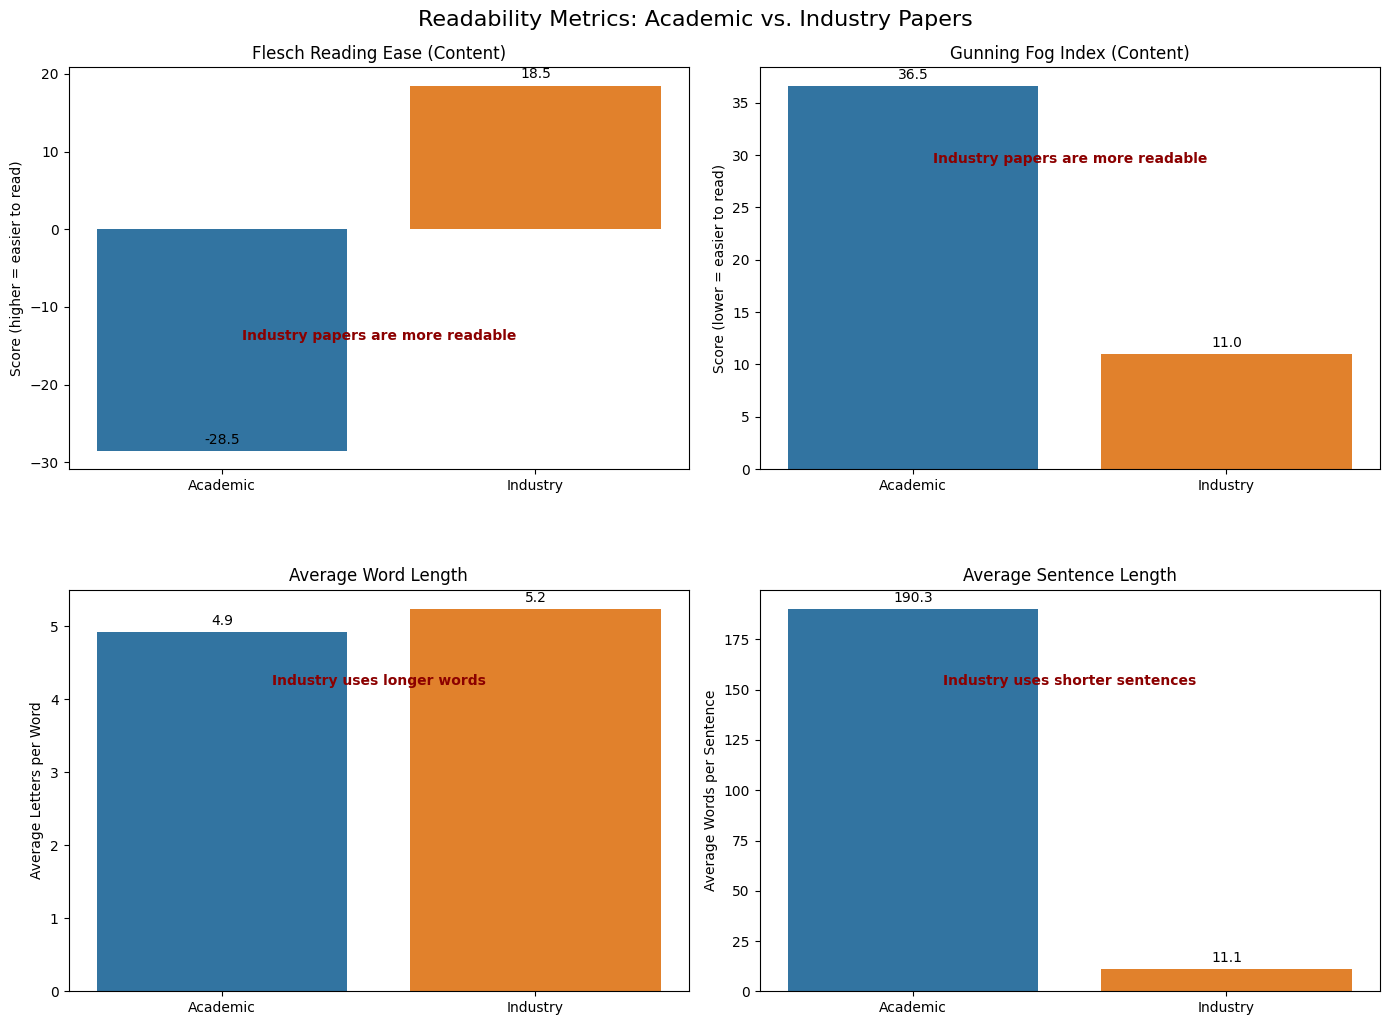

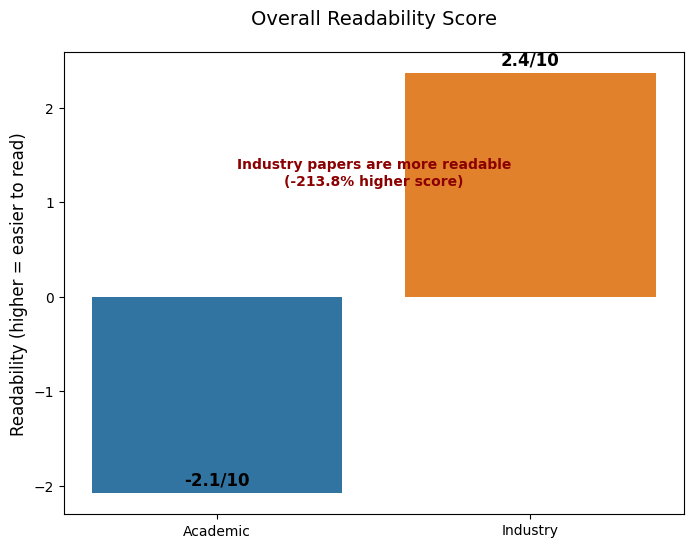

In [17]:
# Install textstat if not already available
try:
    import textstat
except ImportError:
    !pip install textstat
    import textstat

# Function to calculate readability metrics
def calculate_readability_metrics(df, corpus_name="Corpus"):
    """
    Calculate various readability metrics for paper sections
    
    Parameters:
    - df: DataFrame with paper information
    - corpus_name: Name of the corpus for reporting
    
    Returns:
    - Dictionary of readability metrics
    """
    metrics = {
        "corpus_name": corpus_name,
        "num_papers": len(df),
        "title_flesch_ease": [],
        "abstract_flesch_ease": [],
        "content_flesch_ease": [],
        "title_fog_index": [],
        "abstract_fog_index": [],
        "content_fog_index": [],
        "title_smog_index": [],
        "abstract_smog_index": [],
        "content_smog_index": [],
        "title_ari": [], # Automated Readability Index
        "abstract_ari": [],
        "content_ari": [],
        "title_coleman_liau": [],
        "abstract_coleman_liau": [],
        "content_coleman_liau": [],
        "avg_word_length": [],
        "long_words_percent": [], # Percentage of words with more than 6 letters
        "avg_sentence_length": [],
    }
    
    for _, paper in df.iterrows():
        title = str(paper.get('title', ''))
        abstract = str(paper.get('abstract', ''))
        content = str(paper.get('content', ''))
        
        # Skip papers with minimal content
        if len(abstract) < 50 or len(content) < 100:
            continue
            
        try:
            # Calculate Flesch Reading Ease (higher = easier to read)
            if len(title.split()) >= 2:  # Need at least 2 words
                metrics["title_flesch_ease"].append(textstat.flesch_reading_ease(title))
            
            metrics["abstract_flesch_ease"].append(textstat.flesch_reading_ease(abstract))
            metrics["content_flesch_ease"].append(textstat.flesch_reading_ease(content))
            
            # Calculate Gunning Fog Index (higher = more complex)
            if len(title.split()) >= 3:  # Need more words for reliable fog index
                metrics["title_fog_index"].append(textstat.gunning_fog(title))
                
            metrics["abstract_fog_index"].append(textstat.gunning_fog(abstract))
            metrics["content_fog_index"].append(textstat.gunning_fog(content))
            
            # Calculate SMOG Index
            metrics["abstract_smog_index"].append(textstat.smog_index(abstract))
            metrics["content_smog_index"].append(textstat.smog_index(content))
            
            # Calculate Automated Readability Index
            metrics["abstract_ari"].append(textstat.automated_readability_index(abstract))
            metrics["content_ari"].append(textstat.automated_readability_index(content))
            
            # Calculate Coleman-Liau Index
            metrics["abstract_coleman_liau"].append(textstat.coleman_liau_index(abstract))
            metrics["content_coleman_liau"].append(textstat.coleman_liau_index(content))
            
            # Calculate average word length
            words = re.findall(r'\b[a-z0-9]+\b', content.lower())
            if words:
                avg_len = sum(len(word) for word in words) / len(words)
                metrics["avg_word_length"].append(avg_len)
                
                # Calculate percentage of long words (> 6 letters)
                long_words = sum(1 for word in words if len(word) > 6)
                metrics["long_words_percent"].append((long_words / len(words)) * 100)
            
            # Calculate average sentence length
            sentences = re.split(r'[.!?]+', content)
            sentences = [s.strip() for s in sentences if s.strip()]
            if sentences:
                words_per_sentence = sum(len(re.findall(r'\b\w+\b', s)) for s in sentences) / len(sentences)
                metrics["avg_sentence_length"].append(words_per_sentence)
                
        except Exception as e:
            print(f"Error calculating readability metrics for a paper: {e}")
            continue
    
    # Calculate summary statistics
    metrics_to_summarize = [k for k in metrics.keys() if isinstance(metrics[k], list) and metrics[k]]
    
    for metric in metrics_to_summarize:
        metrics[f"{metric}_mean"] = np.mean(metrics[metric])
        metrics[f"{metric}_median"] = np.median(metrics[metric])
        metrics[f"{metric}_std"] = np.std(metrics[metric])
    
    return metrics

# Calculate readability metrics
academic_readability = calculate_readability_metrics(academic_papers, "Academic")
industry_readability = calculate_readability_metrics(industry_papers, "Industry")

# Create comparison table for readability metrics
readability_comparison = pd.DataFrame({
    'Metric': [
        'Flesch Reading Ease (Abstract)',
        'Flesch Reading Ease (Content)', 
        'Gunning Fog Index (Abstract)',
        'Gunning Fog Index (Content)',
        'SMOG Index (Content)',
        'Automated Readability Index (Content)',
        'Coleman-Liau Index (Content)',
        'Average Word Length',
        'Long Words Percentage',
        'Average Sentence Length'
    ],
    'Academic': [
        academic_readability.get('abstract_flesch_ease_mean', 0),
        academic_readability.get('content_flesch_ease_mean', 0),
        academic_readability.get('abstract_fog_index_mean', 0),
        academic_readability.get('content_fog_index_mean', 0),
        academic_readability.get('content_smog_index_mean', 0),
        academic_readability.get('content_ari_mean', 0),
        academic_readability.get('content_coleman_liau_mean', 0),
        academic_readability.get('avg_word_length_mean', 0),
        academic_readability.get('long_words_percent_mean', 0),
        academic_readability.get('avg_sentence_length_mean', 0)
    ],
    'Industry': [
        industry_readability.get('abstract_flesch_ease_mean', 0),
        industry_readability.get('content_flesch_ease_mean', 0),
        industry_readability.get('abstract_fog_index_mean', 0),
        industry_readability.get('content_fog_index_mean', 0),
        industry_readability.get('content_smog_index_mean', 0),
        industry_readability.get('content_ari_mean', 0),
        industry_readability.get('content_coleman_liau_mean', 0),
        industry_readability.get('avg_word_length_mean', 0),
        industry_readability.get('long_words_percent_mean', 0),
        industry_readability.get('avg_sentence_length_mean', 0)
    ]
})

# Calculate differences
readability_comparison['Difference'] = readability_comparison['Industry'] - readability_comparison['Academic']
readability_comparison['Academic'] = readability_comparison['Academic'].round(2)
readability_comparison['Industry'] = readability_comparison['Industry'].round(2)
readability_comparison['Difference'] = readability_comparison['Difference'].round(2)

# Add interpretation column
def interpret_readability_diff(row):
    metric = row['Metric']
    diff = row['Difference']
    
    if 'Flesch Reading' in metric:
        # Higher Flesch score means easier to read
        return "Industry more readable" if diff > 0 else "Academic more readable"
    elif any(x in metric for x in ['Fog', 'SMOG', 'ARI', 'Coleman', 'Word Length', 'Sentence Length']):
        # Lower scores mean easier to read for these metrics
        return "Academic more readable" if diff > 0 else "Industry more readable"
    elif 'Long Words' in metric:
        # Lower percentage means easier to read
        return "Academic more readable" if diff > 0 else "Industry more readable"
    else:
        return "Neutral"

readability_comparison['Interpretation'] = readability_comparison.apply(interpret_readability_diff, axis=1)

# Print the comparison table
print("\nReadability Metrics Comparison:")
print(readability_comparison)

# Create a visualization of key readability metrics
try:
    # Select key metrics for visualization
    viz_metrics = ['Flesch Reading Ease (Content)', 'Gunning Fog Index (Content)', 
                  'Average Word Length', 'Average Sentence Length']
    viz_data = readability_comparison[readability_comparison['Metric'].isin(viz_metrics)].copy()
    
    # Set up the plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i, (idx, row) in enumerate(viz_data.iterrows()):
        metric = row['Metric']
        academic = row['Academic']
        industry = row['Industry']
        
        # Create bar chart
        ax = axes[i]
        x = np.arange(2)
        bars = ax.bar(x, [academic, industry], color=['#3274A1', '#E1812C'])
        
        # Add labels
        ax.set_title(metric, fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(['Academic', 'Industry'])
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom')
        
        # Add interpretation
        if 'Flesch' in metric:
            ax.set_ylabel('Score (higher = easier to read)')
            ax.text(0.5, academic * 0.5, 
                  "Industry papers are " + ("more readable" if industry > academic else "less readable"), 
                  ha='center', color='darkred', fontweight='bold')
        elif 'Fog' in metric:
            ax.set_ylabel('Score (lower = easier to read)')
            ax.text(0.5, max(academic, industry) * 0.8, 
                  "Industry papers are " + ("less readable" if industry > academic else "more readable"), 
                  ha='center', color='darkred', fontweight='bold')
        elif 'Word Length' in metric:
            ax.set_ylabel('Average Letters per Word')
            ax.text(0.5, max(academic, industry) * 0.8, 
                  "Industry uses " + ("longer" if industry > academic else "shorter") + " words", 
                  ha='center', color='darkred', fontweight='bold')
        elif 'Sentence Length' in metric:
            ax.set_ylabel('Average Words per Sentence')
            ax.text(0.5, max(academic, industry) * 0.8, 
                  "Industry uses " + ("longer" if industry > academic else "shorter") + " sentences", 
                  ha='center', color='darkred', fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    plt.suptitle('Readability Metrics: Academic vs. Industry Papers', fontsize=16, y=1.02)
    plt.savefig('readability_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create a summary visualization: Overall Readability Score
    # Combine multiple metrics into one standardized score
    # Higher = more readable
    try:
        # Flesch (higher = more readable)
        academic_flesch = academic_readability.get('content_flesch_ease_mean', 0)
        industry_flesch = industry_readability.get('content_flesch_ease_mean', 0)
        
        # Fog and SMOG (lower = more readable) - invert these
        academic_fog = academic_readability.get('content_fog_index_mean', 0)
        industry_fog = industry_readability.get('content_fog_index_mean', 0)
        academic_smog = academic_readability.get('content_smog_index_mean', 0)
        industry_smog = industry_readability.get('content_smog_index_mean', 0)
        
        # Normalize and combine (higher = more readable)
        academic_score = academic_flesch/100 - (academic_fog/20) - (academic_smog/20)
        industry_score = industry_flesch/100 - (industry_fog/20) - (industry_smog/20)
        
        # Rescale to 0-10 range
        rescaled_academic = (academic_score + 2) * 2.5
        rescaled_industry = (industry_score + 2) * 2.5
        
        # Create bar chart
        plt.figure(figsize=(8, 6))
        bars = plt.bar([0, 1], [rescaled_academic, rescaled_industry], color=['#3274A1', '#E1812C'])
        plt.title('Overall Readability Score', fontsize=14, pad=20)
        plt.ylabel('Readability (higher = easier to read)', fontsize=12)
        plt.xticks([0, 1], ['Academic', 'Industry'])
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{height:.1f}/10',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom',
                       fontsize=12, fontweight='bold')
        
        # Add interpretation
        if rescaled_industry > rescaled_academic:
            plt.text(0.5, max(rescaled_academic, rescaled_industry) * 0.5, 
                   f"Industry papers are more readable\n({((rescaled_industry/rescaled_academic)-1)*100:.1f}% higher score)", 
                   ha='center', color='darkred', fontweight='bold')
        else:
            plt.text(0.5, max(rescaled_academic, rescaled_industry) * 0.5, 
                   f"Academic papers are more readable\n({((rescaled_academic/rescaled_industry)-1)*100:.1f}% higher score)", 
                   ha='center', color='darkred', fontweight='bold')
        
        plt.savefig('overall_readability.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(f"Error creating overall readability visualization: {e}")
    
except Exception as e:
    print(f"Error creating readability visualizations: {e}")


Lexical Diversity Metrics Comparison:
                               Metric  Academic  Industry  Difference  % Difference         Interpretation
0        Type-Token Ratio (Full Text)      0.32      0.27       -0.05         -15.6  Academic more diverse
1          Type-Token Ratio (Content)      0.32      0.27       -0.05         -15.6  Academic more diverse
2         Type-Token Ratio (Abstract)      0.71      0.65       -0.05          -8.5  Academic more diverse
3   Hapax Percentage (Unique Words %)     30.40     22.60       -7.80         -25.7  Academic more diverse
4           Top 50 Words Coverage (%)     34.53     30.66       -3.87         -11.2  Industry more diverse
5    Vocabulary Richness (Herdan's C)      0.89      0.88       -0.02          -1.1  Academic more diverse
6  Yule's K (Vocabulary Distribution)     37.07     33.40       -3.67          -9.9  Industry more diverse
7              Unique Words per Paper   1139.80   1648.99      509.19          44.7  Industry more divers

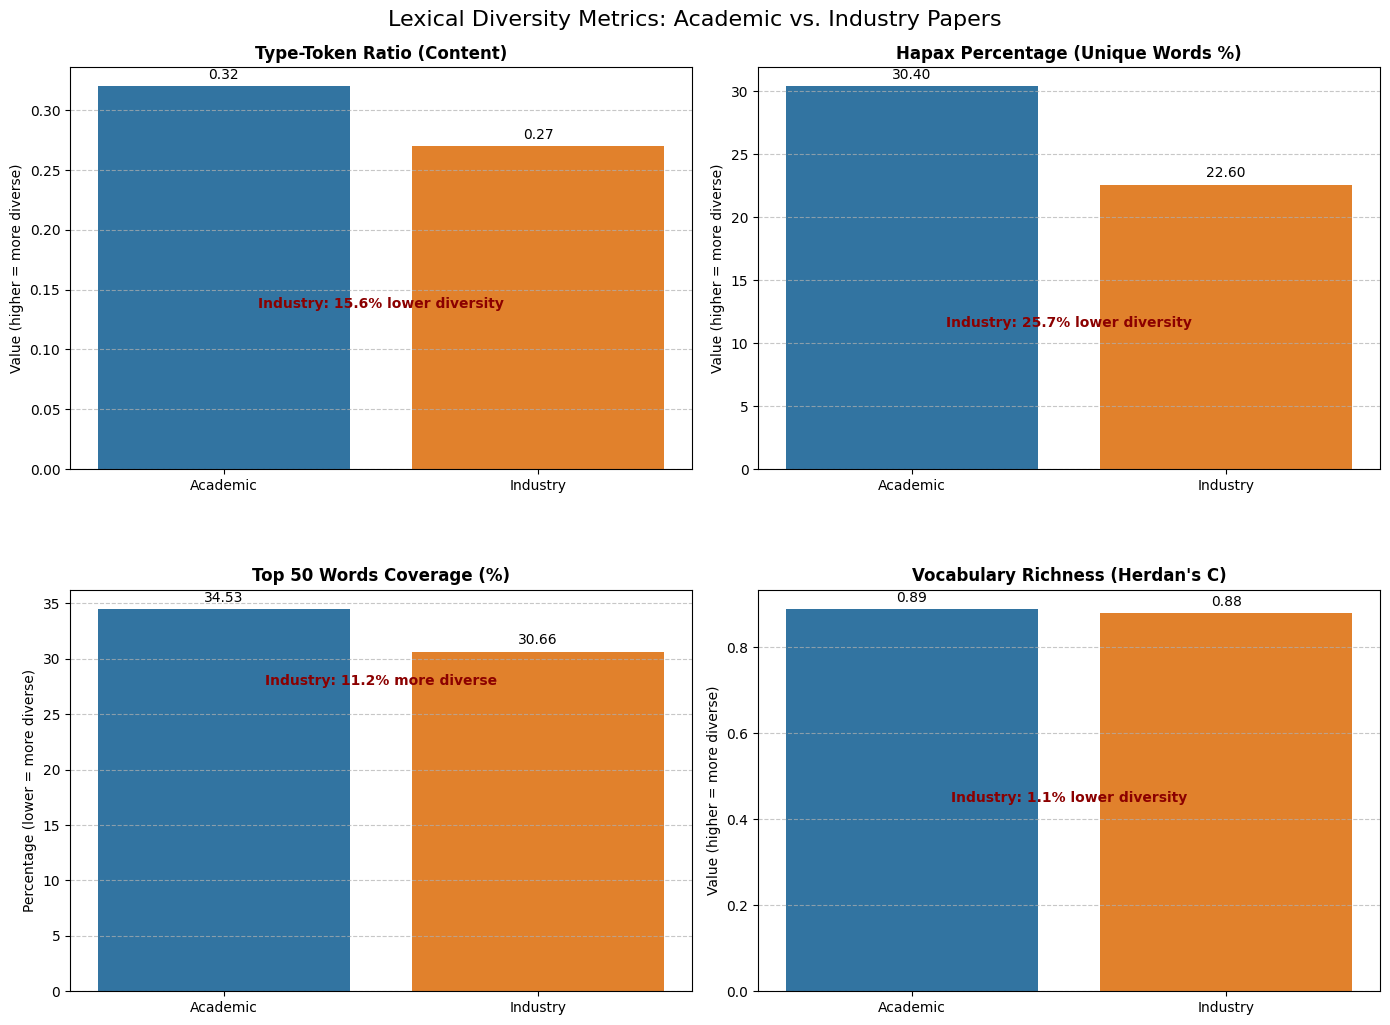

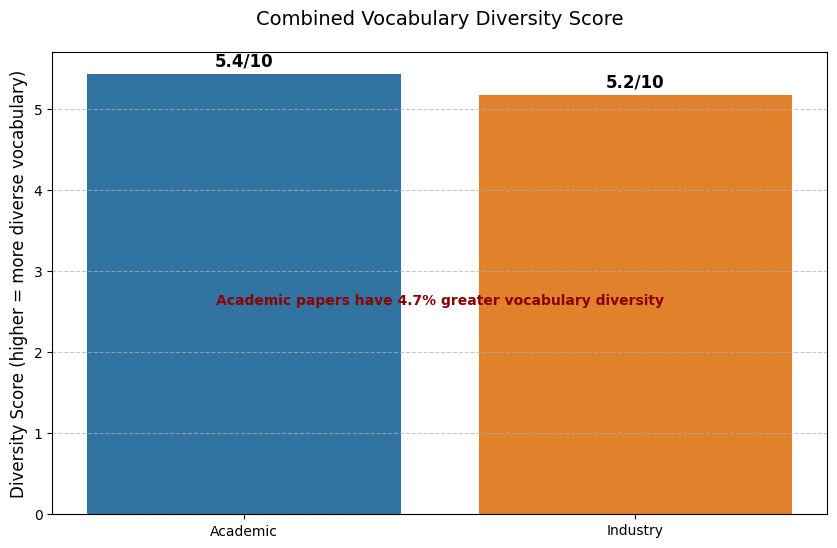

In [18]:
# Import required libraries for lexical diversity
import nltk
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist

# Function to calculate lexical diversity metrics
def calculate_diversity_metrics(df, corpus_name="Corpus"):
    """
    Calculate various lexical diversity metrics for papers
    
    Parameters:
    - df: DataFrame with paper information
    - corpus_name: Name of the corpus for reporting
    
    Returns:
    - Dictionary of diversity metrics
    """
    metrics = {
        "corpus_name": corpus_name,
        "num_papers": len(df),
        "ttr": [],  # Type-Token Ratio
        "ttr_content": [],  # TTR for content only
        "ttr_abstract": [],  # TTR for abstracts only
        "hapax_percentage": [],  # Percentage of words that appear only once
        "hapax_content": [],
        "top_50_coverage": [],  # % of text covered by top 50 words
        "top_50_content": [],
        "vocab_richness": [],  # Herdan's C (logarithmic TTR)
        "vocab_richness_content": [],
        "yule_k": [],  # Yule's K measure (vocabulary distribution)
        "yule_k_content": [],
        "corpus_unique_words": set(),  # Unique words in the entire corpus
        "avg_unique_per_paper": [],  # Average unique words per paper
        "rare_words_ratio": [],  # Words that appear in less than 5% of corpus documents
    }
    
    # Get stopwords
    stop_words = set(stopwords.words('english'))
    
    # Process each paper
    corpus_words = []
    paper_word_sets = []
    
    for _, paper in df.iterrows():
        abstract = str(paper.get('abstract', ''))
        content = str(paper.get('content', ''))
        full_text = abstract + " " + content
        
        # Skip papers with minimal content
        if len(abstract) < 50 or len(content) < 100:
            continue
            
        try:
            # Tokenize text and clean tokens
            tokens = word_tokenize(full_text.lower())
            tokens = [word for word in tokens if word.isalpha() and len(word) > 1]
            
            # Get non-stopword tokens
            content_tokens = [word for word in tokens if word not in stop_words]
            
            # Add to corpus collection
            corpus_words.extend(content_tokens)
            paper_word_sets.append(set(content_tokens))
            
            # Store unique words for the corpus
            metrics["corpus_unique_words"].update(content_tokens)
            metrics["avg_unique_per_paper"].append(len(set(content_tokens)))
            
            # Calculate Type-Token Ratio (measure of vocabulary richness)
            if tokens:
                metrics["ttr"].append(len(set(tokens)) / len(tokens))
            
            # TTR for content only
            content_only_tokens = word_tokenize(content.lower())
            content_only_tokens = [word for word in content_only_tokens if word.isalpha() and len(word) > 1]
            if content_only_tokens:
                metrics["ttr_content"].append(len(set(content_only_tokens)) / len(content_only_tokens))
            
            # TTR for abstract only
            abstract_only_tokens = word_tokenize(abstract.lower())
            abstract_only_tokens = [word for word in abstract_only_tokens if word.isalpha() and len(word) > 1]
            if abstract_only_tokens:
                metrics["ttr_abstract"].append(len(set(abstract_only_tokens)) / len(abstract_only_tokens))
            
            # Calculate hapax percentage (words appearing only once)
            word_freq = Counter(content_tokens)
            hapax_words = [word for word, count in word_freq.items() if count == 1]
            metrics["hapax_percentage"].append(len(hapax_words) / len(content_tokens) * 100)
            
            # Same for content only
            content_word_freq = Counter(content_only_tokens)
            content_hapax = [word for word, count in content_word_freq.items() if count == 1]
            if content_only_tokens:
                metrics["hapax_content"].append(len(content_hapax) / len(content_only_tokens) * 100)
            
            # Calculate top 50 words coverage
            top_50_count = sum([count for word, count in word_freq.most_common(50)])
            metrics["top_50_coverage"].append(top_50_count / len(content_tokens) * 100)
            
            # Same for content only
            if content_only_tokens:
                content_top_50_count = sum([count for word, count in content_word_freq.most_common(50)])
                metrics["top_50_content"].append(content_top_50_count / len(content_only_tokens) * 100)
            
            # Calculate Herdan's C (log TTR)
            if content_tokens:
                metrics["vocab_richness"].append(np.log(len(set(content_tokens))) / np.log(len(content_tokens)))
            
            if content_only_tokens:
                metrics["vocab_richness_content"].append(
                    np.log(len(set(content_only_tokens))) / np.log(len(content_only_tokens))
                )
            
            # Calculate Yule's K measure (vocabulary distribution richness)
            try:
                # Formula: K = 10^4 * (M - N) / (N^2)
                # where M is the sum of the products of each frequency squared and the number of words with that frequency
                # and N is the total number of tokens
                freqs = Counter(content_tokens)
                freq_spectrum = Counter([count for word, count in freqs.items()])
                M = sum([(freq ** 2) * count for freq, count in freq_spectrum.items()])
                N = len(content_tokens)
                yule_k = 10000 * (M - N) / (N ** 2) if N > 0 else 0
                metrics["yule_k"].append(yule_k)
                
                # Same for content only
                content_freqs = Counter(content_only_tokens)
                content_freq_spectrum = Counter([count for word, count in content_freqs.items()])
                content_M = sum([(freq ** 2) * count for freq, count in content_freq_spectrum.items()])
                content_N = len(content_only_tokens)
                content_yule_k = 10000 * (content_M - content_N) / (content_N ** 2) if content_N > 0 else 0
                metrics["yule_k_content"].append(content_yule_k)
            except Exception as e:
                print(f"Error calculating Yule's K: {e}")
            
        except Exception as e:
            print(f"Error calculating diversity metrics for a paper: {e}")
            continue
    
    # Calculate rare words (appear in less than 5% of documents)
    if paper_word_sets:
        word_doc_count = Counter()
        for word_set in paper_word_sets:
            for word in word_set:
                word_doc_count[word] += 1
        
        doc_threshold = 0.05 * len(paper_word_sets)
        rare_words = [word for word, count in word_doc_count.items() if count <= doc_threshold]
        
        # Calculate ratio of rare words to all unique words
        metrics["rare_words_ratio"] = len(rare_words) / len(metrics["corpus_unique_words"]) * 100
    else:
        metrics["rare_words_ratio"] = 0
    
    # Calculate summary statistics for list metrics
    metrics_to_summarize = [k for k in metrics.keys() 
                           if isinstance(metrics[k], list) and metrics[k]]
    
    for metric in metrics_to_summarize:
        metrics[f"{metric}_mean"] = np.mean(metrics[metric])
        metrics[f"{metric}_median"] = np.median(metrics[metric])
        metrics[f"{metric}_std"] = np.std(metrics[metric])
    
    return metrics

# Calculate diversity metrics
try:
    academic_diversity = calculate_diversity_metrics(academic_papers, "Academic")
    industry_diversity = calculate_diversity_metrics(industry_papers, "Industry")

    # Create comparison table
    diversity_comparison = pd.DataFrame({
        'Metric': [
            'Type-Token Ratio (Full Text)',
            'Type-Token Ratio (Content)',
            'Type-Token Ratio (Abstract)', 
            'Hapax Percentage (Unique Words %)',
            'Top 50 Words Coverage (%)',
            'Vocabulary Richness (Herdan\'s C)',
            'Yule\'s K (Vocabulary Distribution)',
            'Unique Words per Paper',
            'Rare Words Ratio (%)'
        ],
        'Academic': [
            academic_diversity.get('ttr_mean', 0),
            academic_diversity.get('ttr_content_mean', 0),
            academic_diversity.get('ttr_abstract_mean', 0),
            academic_diversity.get('hapax_percentage_mean', 0),
            academic_diversity.get('top_50_coverage_mean', 0),
            academic_diversity.get('vocab_richness_mean', 0),
            academic_diversity.get('yule_k_mean', 0),
            academic_diversity.get('avg_unique_per_paper_mean', 0),
            academic_diversity.get('rare_words_ratio', 0)
        ],
        'Industry': [
            industry_diversity.get('ttr_mean', 0),
            industry_diversity.get('ttr_content_mean', 0),
            industry_diversity.get('ttr_abstract_mean', 0),
            industry_diversity.get('hapax_percentage_mean', 0),
            industry_diversity.get('top_50_coverage_mean', 0),
            industry_diversity.get('vocab_richness_mean', 0),
            industry_diversity.get('yule_k_mean', 0),
            industry_diversity.get('avg_unique_per_paper_mean', 0),
            industry_diversity.get('rare_words_ratio', 0)
        ]
    })

    # Calculate differences
    diversity_comparison['Difference'] = diversity_comparison['Industry'] - diversity_comparison['Academic']
    diversity_comparison['Academic'] = diversity_comparison['Academic'].round(2)
    diversity_comparison['Industry'] = diversity_comparison['Industry'].round(2)
    diversity_comparison['Difference'] = diversity_comparison['Difference'].round(2)
    
    # Calculate percentage difference
    diversity_comparison['% Difference'] = ((diversity_comparison['Industry'] / diversity_comparison['Academic']) - 1) * 100
    diversity_comparison['% Difference'] = diversity_comparison['% Difference'].round(1)
    
    # Add interpretation column
    def interpret_diversity_diff(row):
        metric = row['Metric']
        diff = row['Difference']
        
        if 'Type-Token' in metric or 'Hapax' in metric or 'Vocabulary Richness' in metric or 'Unique Words' in metric or 'Rare Words' in metric:
            # Higher values mean more diverse vocabulary
            return "Industry more diverse" if diff > 0 else "Academic more diverse"
        elif 'Top 50 Words Coverage' in metric:
            # Lower values mean more diverse vocabulary
            return "Academic more diverse" if diff > 0 else "Industry more diverse"
        elif 'Yule\'s K' in metric:
            # Lower values mean more diverse vocabulary
            return "Academic more diverse" if diff > 0 else "Industry more diverse"
        else:
            return "Neutral"

    diversity_comparison['Interpretation'] = diversity_comparison.apply(interpret_diversity_diff, axis=1)

    # Print the comparison table
    print("\nLexical Diversity Metrics Comparison:")
    print(diversity_comparison)

    # Create visualizations
    try:
        # Select key metrics for visualization
        viz_metrics = ['Type-Token Ratio (Content)', 'Hapax Percentage (Unique Words %)', 
                     'Top 50 Words Coverage (%)', 'Vocabulary Richness (Herdan\'s C)']
        viz_data = diversity_comparison[diversity_comparison['Metric'].isin(viz_metrics)].copy()
        
        # Set up the plot
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        # Create a custom colormap
        colors = ['#3274A1', '#E1812C']  # Blue for academic, Orange for industry
        
        for i, (idx, row) in enumerate(viz_data.iterrows()):
            metric = row['Metric']
            academic = row['Academic']
            industry = row['Industry']
            
            # Create bar chart
            ax = axes[i]
            x = np.arange(2)
            bars = ax.bar(x, [academic, industry], color=colors)
            
            # Add labels
            ax.set_title(metric, fontsize=12, fontweight='bold')
            ax.set_xticks(x)
            ax.set_xticklabels(['Academic', 'Industry'])
            
            # Add value labels
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.2f}',
                          xy=(bar.get_x() + bar.get_width() / 2, height),
                          xytext=(0, 3),  # 3 points vertical offset
                          textcoords="offset points",
                          ha='center', va='bottom')
            
            # Add interpretation
            if 'Type-Token' in metric or 'Hapax' in metric or 'Vocabulary Richness' in metric:
                ax.set_ylabel('Value (higher = more diverse)')
                diff_pct = ((industry - academic) / academic) * 100
                direction = "higher" if industry > academic else "lower"
                ax.text(0.5, min(academic, industry) * 0.5, 
                      f"Industry: {abs(diff_pct):.1f}% {direction} diversity", 
                      ha='center', color='darkred', fontweight='bold')
            elif 'Top 50 Words' in metric:
                ax.set_ylabel('Percentage (lower = more diverse)')
                diff_pct = ((industry - academic) / academic) * 100
                direction = "less" if industry > academic else "more"
                ax.text(0.5, max(academic, industry) * 0.8, 
                      f"Industry: {abs(diff_pct):.1f}% {direction} diverse", 
                      ha='center', color='darkred', fontweight='bold')
            
            # Add grid
            ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        plt.suptitle('Lexical Diversity Metrics: Academic vs. Industry Papers', fontsize=16, y=1.02)
        plt.savefig('lexical_diversity_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Create a combined score visualization
        plt.figure(figsize=(10, 6))
        
        # Create a normalized combined diversity score (higher = more diverse)
        # We'll normalize and combine:
        # 1. TTR (higher = more diverse)
        # 2. Hapax percentage (higher = more diverse)
        # 3. Top 50 coverage (lower = more diverse, so invert)
        # 4. Herdan's C (higher = more diverse)
        
        # Extract values
        academic_ttr = academic_diversity.get('ttr_content_mean', 0)
        industry_ttr = industry_diversity.get('ttr_content_mean', 0)
        
        academic_hapax = academic_diversity.get('hapax_percentage_mean', 0) / 100  # Scale to 0-1
        industry_hapax = industry_diversity.get('hapax_percentage_mean', 0) / 100
        
        academic_top50 = 1 - (academic_diversity.get('top_50_coverage_mean', 0) / 100)  # Invert and scale to 0-1
        industry_top50 = 1 - (industry_diversity.get('top_50_coverage_mean', 0) / 100)
        
        academic_herdan = academic_diversity.get('vocab_richness_mean', 0)
        industry_herdan = industry_diversity.get('vocab_richness_mean', 0)
        
        # Combine scores (simple average)
        academic_combined = (academic_ttr + academic_hapax + academic_top50 + academic_herdan) / 4
        industry_combined = (industry_ttr + industry_hapax + industry_top50 + industry_herdan) / 4
        
        # Scale to 0-10
        academic_score = academic_combined * 10
        industry_score = industry_combined * 10
        
        # Create bar chart
        bars = plt.bar([0, 1], [academic_score, industry_score], color=colors)
        plt.title('Combined Vocabulary Diversity Score', fontsize=14, pad=20)
        plt.ylabel('Diversity Score (higher = more diverse vocabulary)', fontsize=12)
        plt.xticks([0, 1], ['Academic', 'Industry'])
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{height:.1f}/10',
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom',
                      fontsize=12, fontweight='bold')
        
        # Add interpretation
        diff_pct = ((industry_score / academic_score) - 1) * 100
        if industry_score > academic_score:
            plt.text(0.5, min(academic_score, industry_score) * 0.5, 
                  f"Industry papers have {diff_pct:.1f}% greater vocabulary diversity", 
                  ha='center', color='darkred', fontweight='bold')
        else:
            plt.text(0.5, min(academic_score, industry_score) * 0.5, 
                  f"Academic papers have {-diff_pct:.1f}% greater vocabulary diversity", 
                  ha='center', color='darkred', fontweight='bold')
        
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.savefig('combined_diversity_score.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(f"Error creating diversity visualizations: {e}")
        import traceback
        traceback.print_exc()

except Exception as e:
    print(f"Error calculating diversity metrics: {e}")
    import traceback
    traceback.print_exc()